In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import transformers
import torch
import os
import nltk
import pandas as pd
import torch
import numpy as np
from jinja2 import Template
import pickle
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('/scratch/users/bozyurt20/hpc_run/utilities')
sys.path.append("/scratch/users/bozyurt20/hpc_run/blobs/")
from util_research import *

max_len = 512
num_layers = 24
d_model = 4096

tokenizer = AutoTokenizer.from_pretrained("bigscience/T0pp", truncation_side="right", add_prefix_space=True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model = AutoModelForSeq2SeqLM.from_pretrained("bigscience/T0pp", device_map="balanced", load_in_8bit=True, output_attentions=True)
#model = AutoModelForSeq2SeqLM.from_pretrained("bigscience/T0pp", output_attentions=True)
#device = torch.device("cpu")

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


# One Sentence

In [10]:
names_1 = ["John", "Harry", "Andrew", "Lisa", "Mary"]
names_2 = ["Henry", "David", "Sophia", "Olivia", "Emma"]

cities_1 = ["London", "Paris", "Oslo", "Istanbul", "Beijing"]
cities_2 = ["Sydney", "Cairo", "Seoul", "Rome", "Prague"]

class DataSample_OneSentence():
    def __init__(self, name_1, city_1):
        self.name_1 = name_1
        self.city_1 = city_1
        self.context = name_1 + " travelled to " + city_1 + ". Where did " + name_1 + " travel to?"
        
data_points_one_sentence = []
for name_1 in names_1 + names_2:
    for city_1 in cities_1 + cities_2:
        sample = DataSample_OneSentence(name_1, city_1)
        data_points_one_sentence.append(sample)

In [11]:
template = tm8
for sample in data_points_one_sentence[0:1]:
    context = sample.context
    question = sample.question_1
    answer = sample.answer_1
    prompt = template.render(context=context, question=question)
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    model_output = model.generate(input_ids, max_new_tokens=1, output_scores=True, return_dict_in_generate=True)

new code working-utils
new code working-modeling_t5
llama generation happening.
new code working-modeling_t5


In [81]:
enc_attn = model_output.encoder_attentions
dec_attn = model_output.decoder_attentions
cross_attn = model_output.cross_attentions

In [112]:
src_seq = tokenizer.tokenize(prompt, add_special_tokens=True)
out_seq = tokenizer.tokenize(out_decoded)

In [100]:
len(cross_attn)

5

0


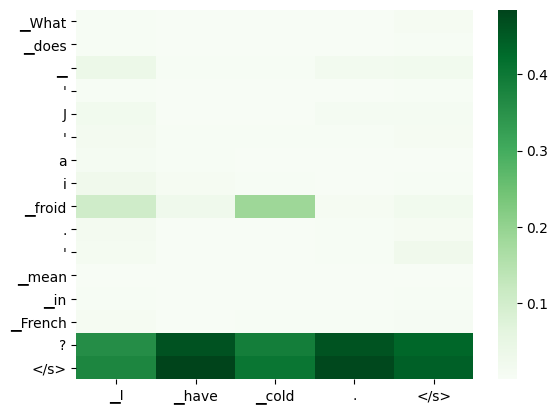

1


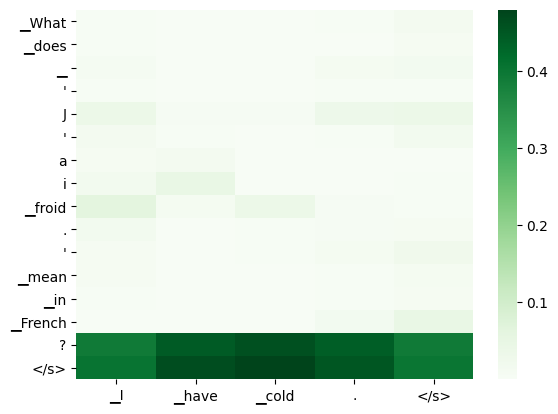

2


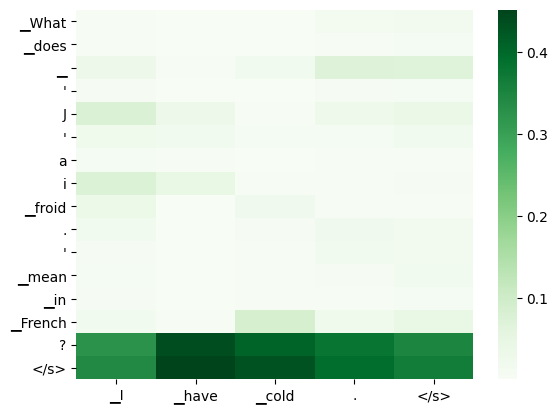

3


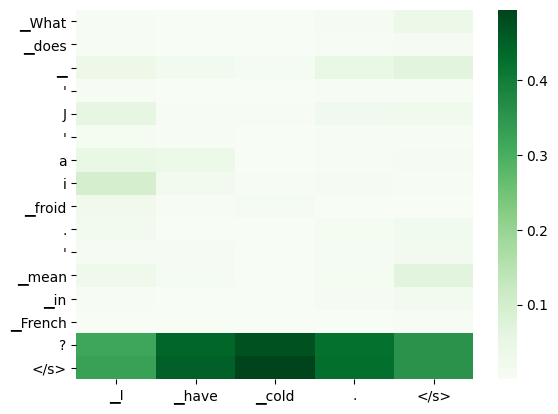

4


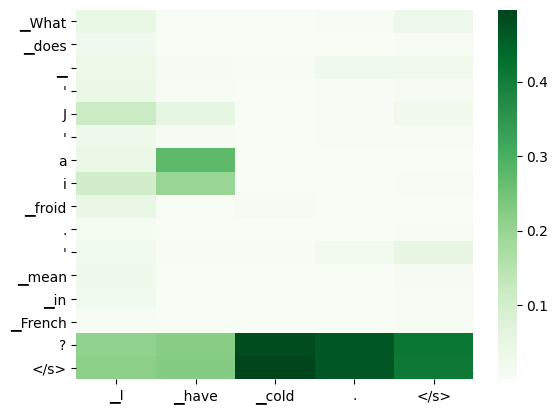

5


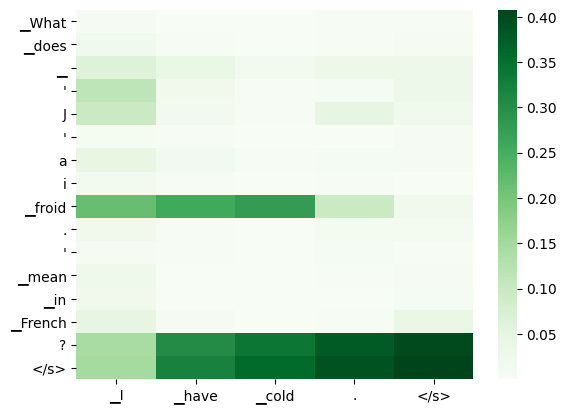

6


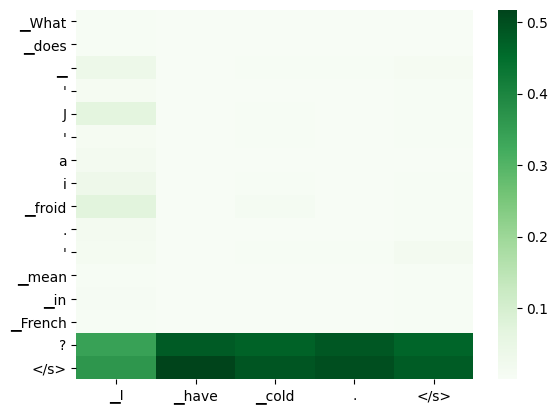

7


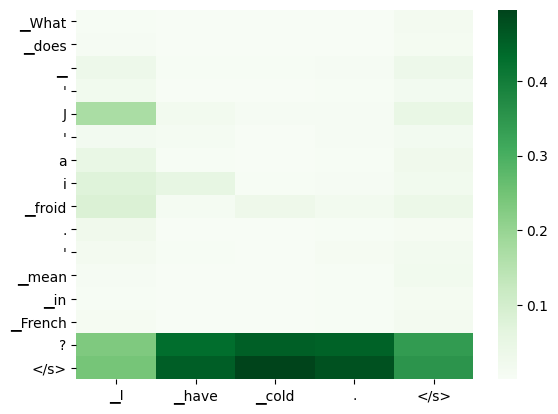

8


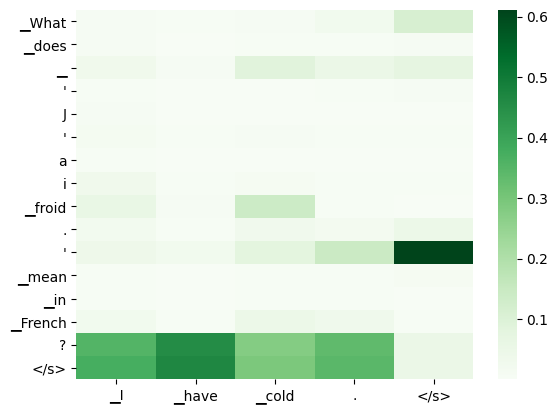

9


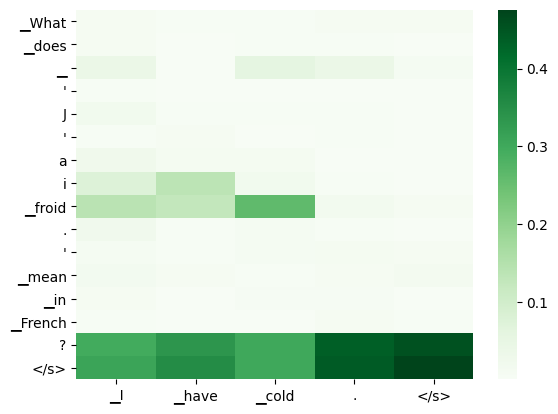

10


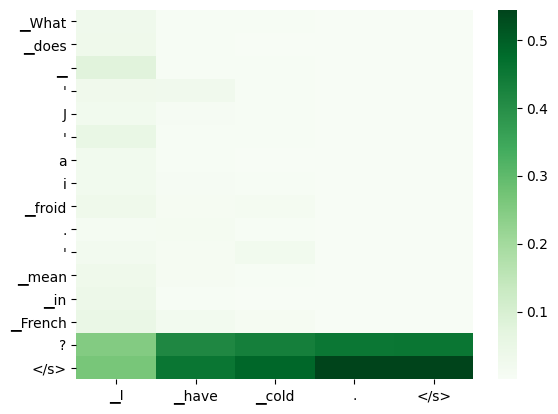

11


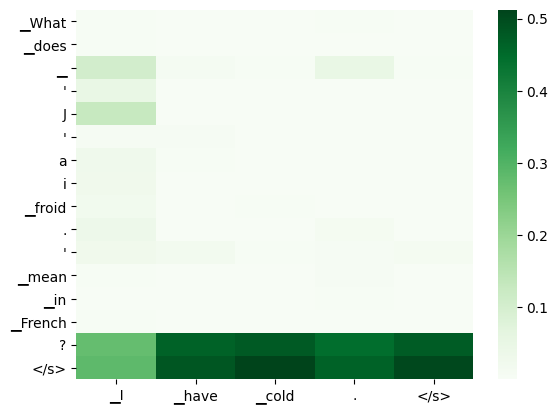

12


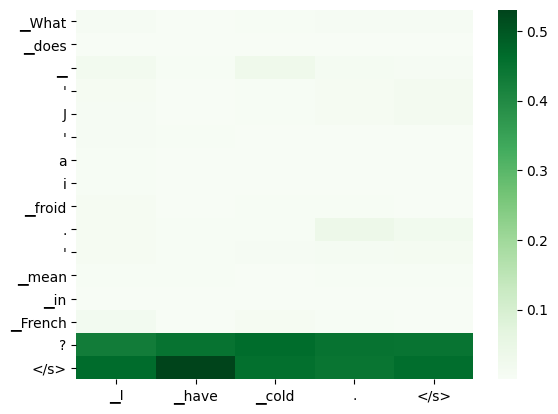

13


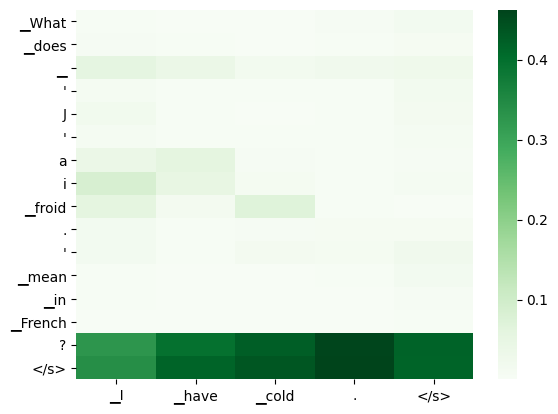

14


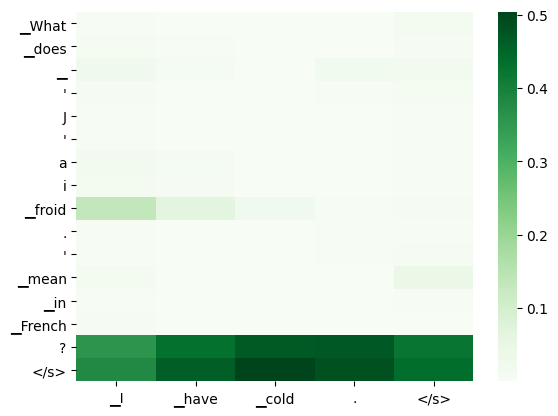

15


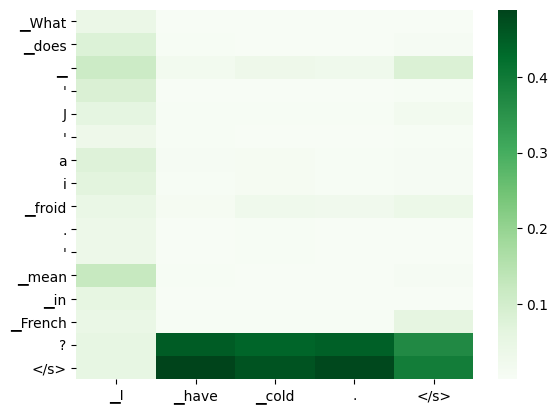

16


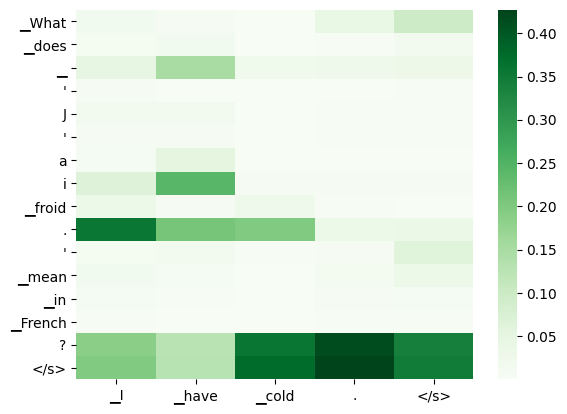

17


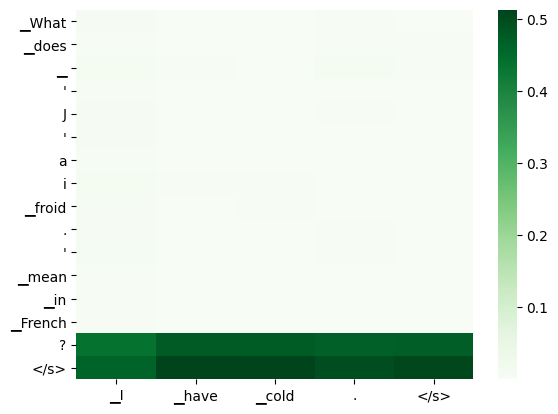

18


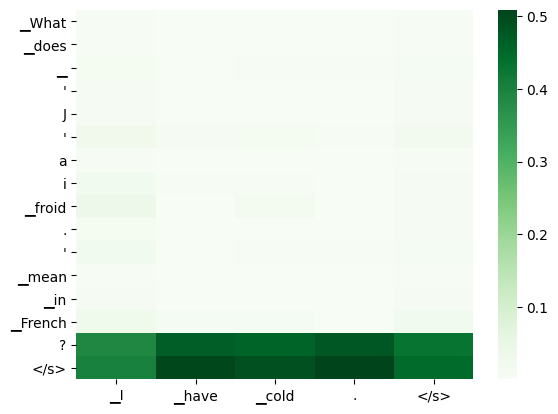

19


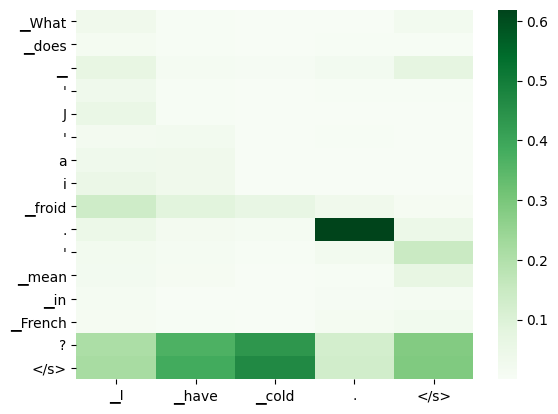

20


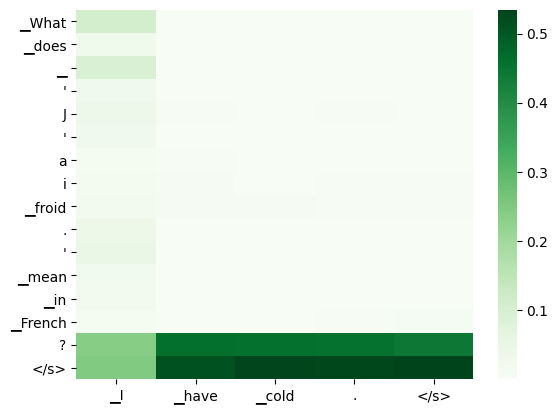

21


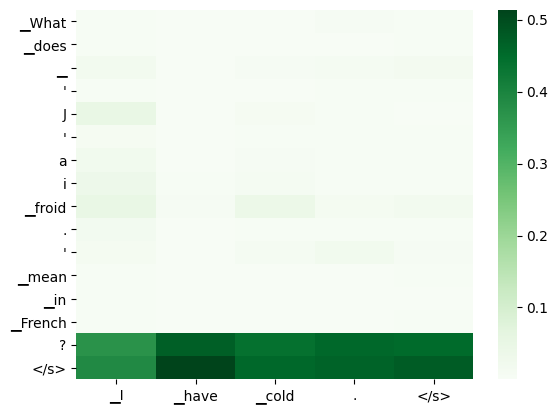

22


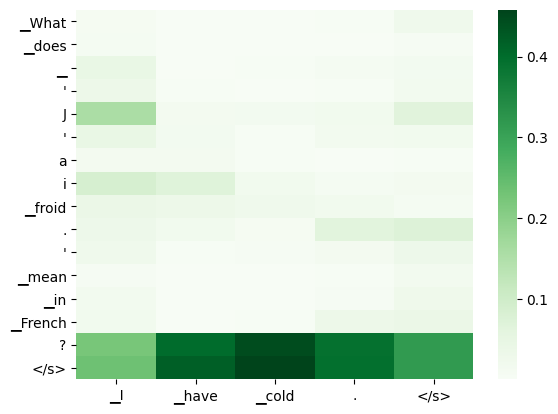

23


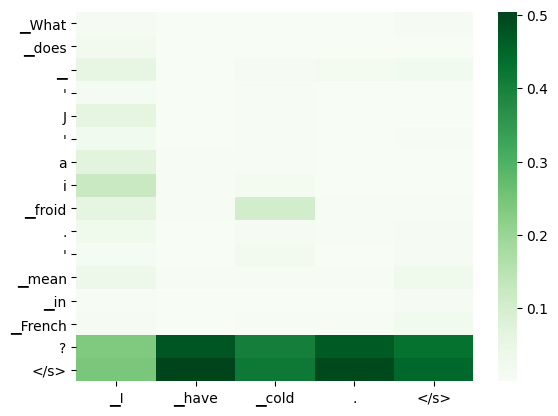

24


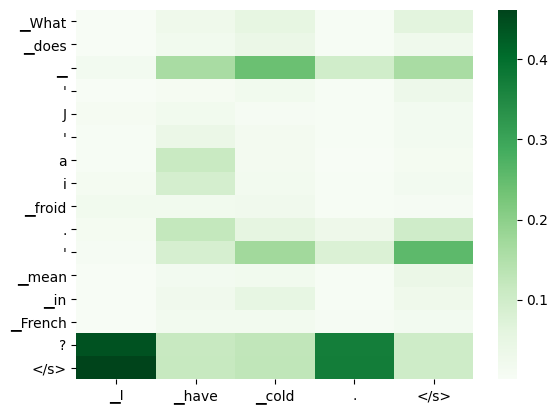

25


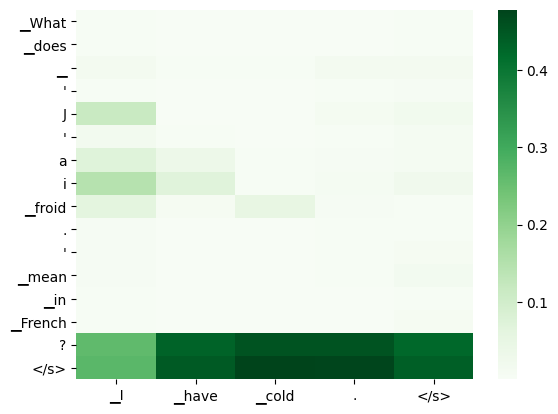

26


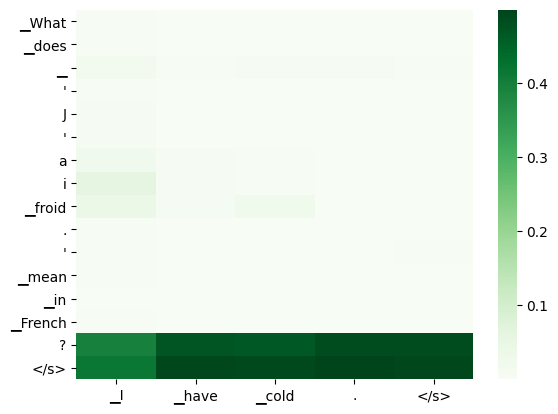

27


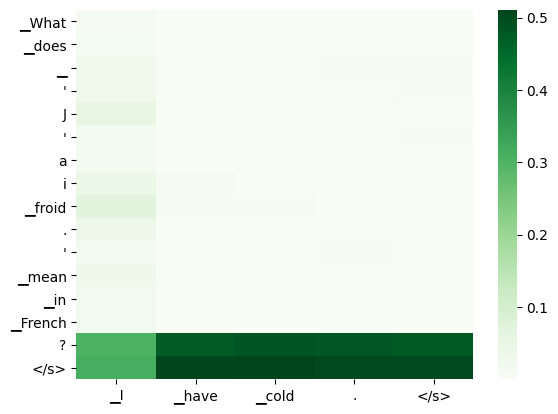

28


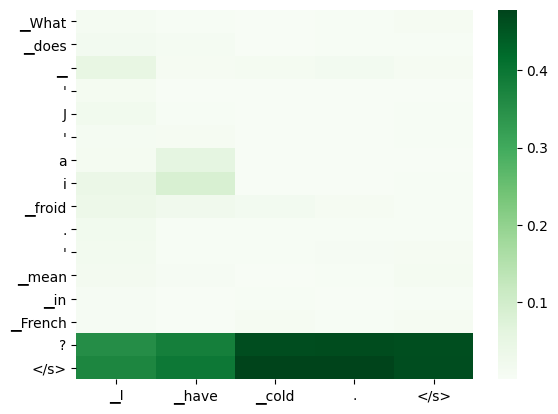

29


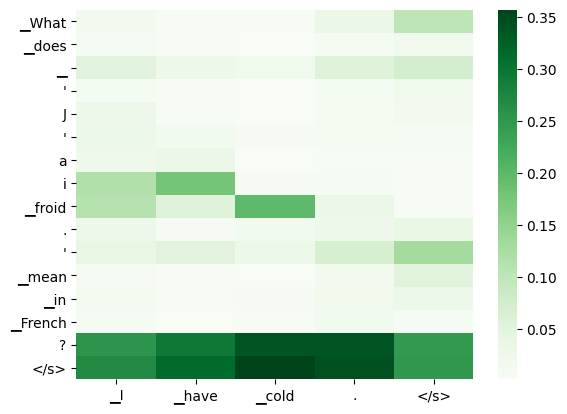

30


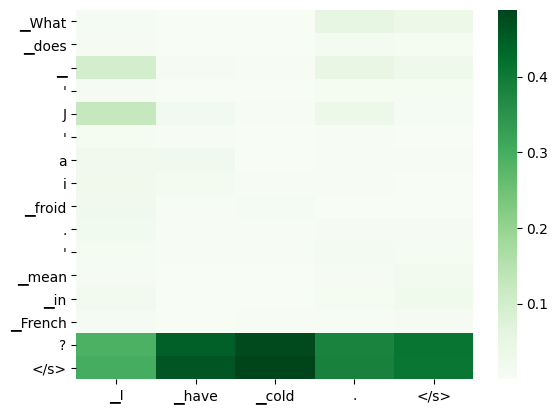

31


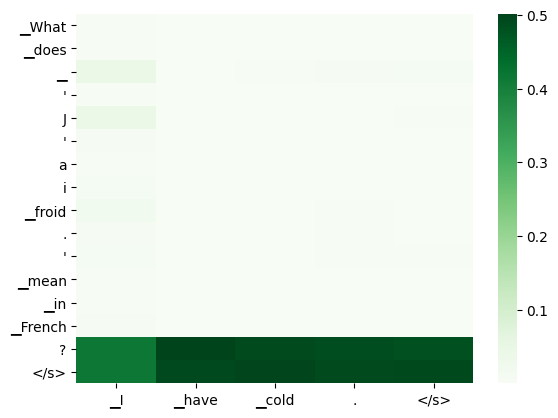

32


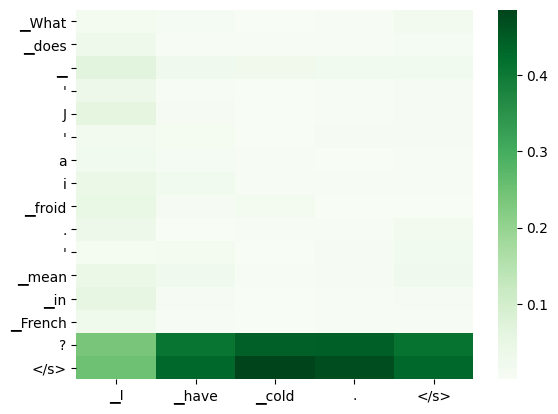

33


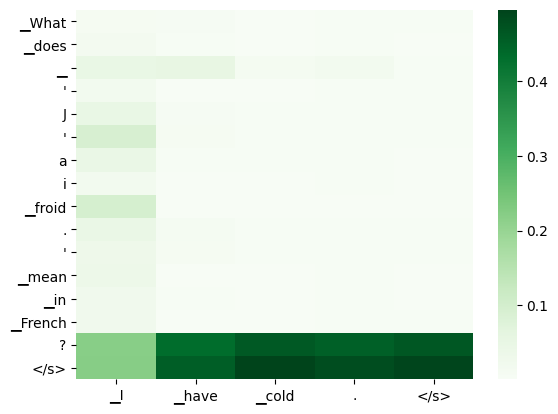

34


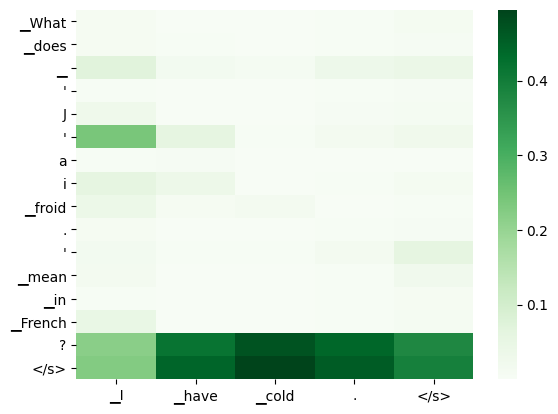

35


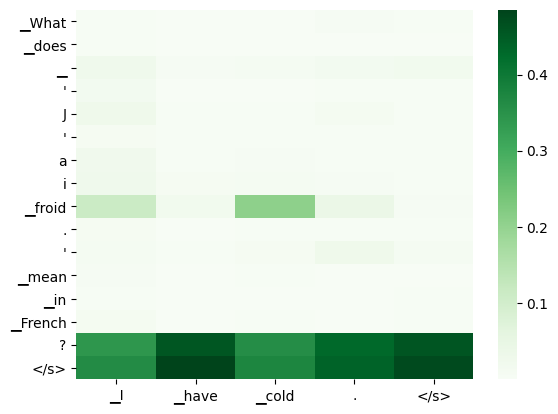

36


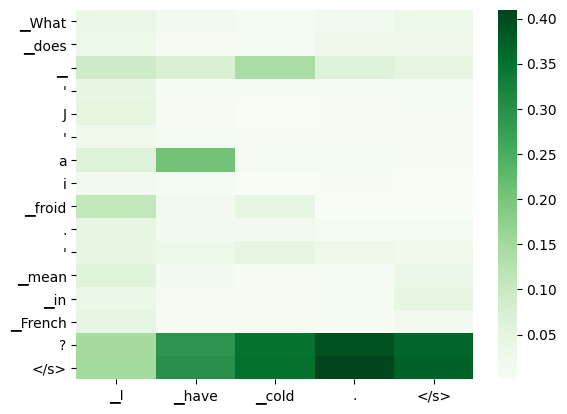

37


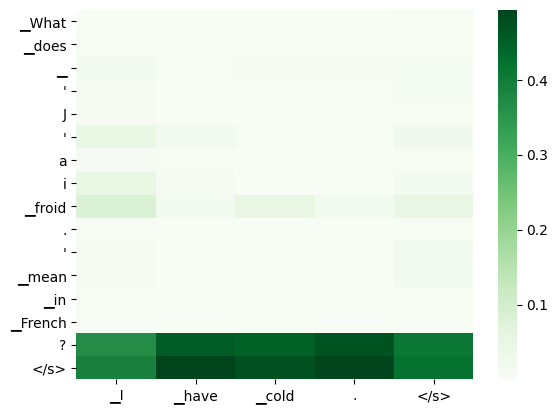

38


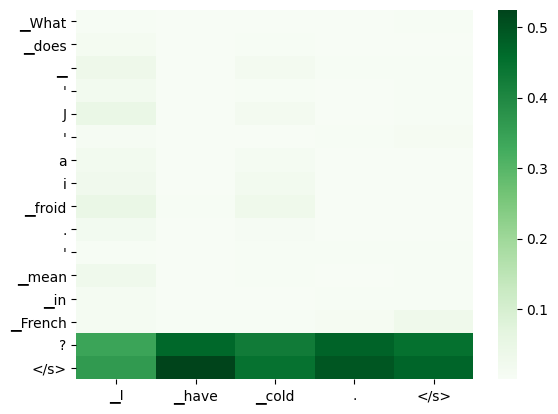

39


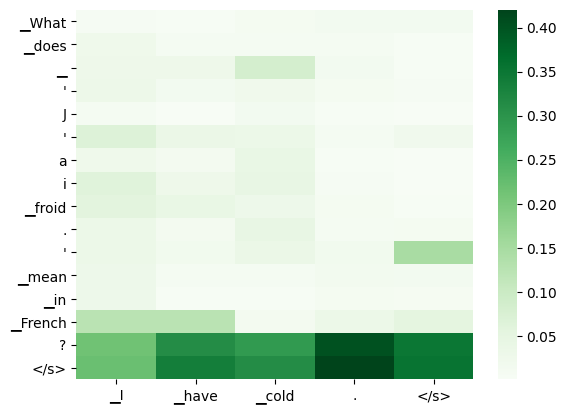

40


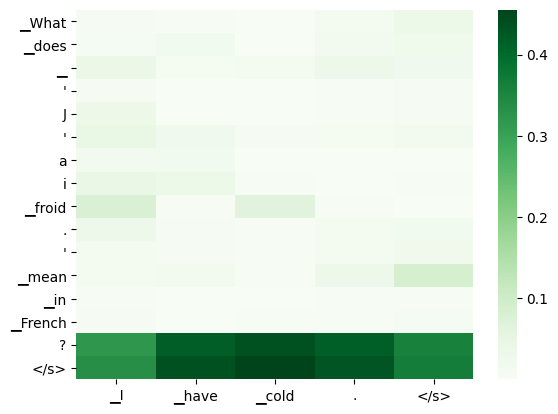

41


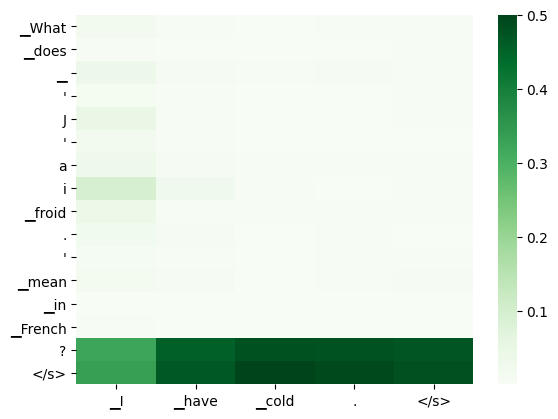

42


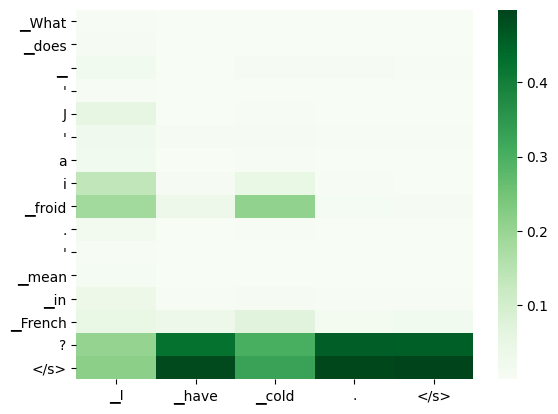

43


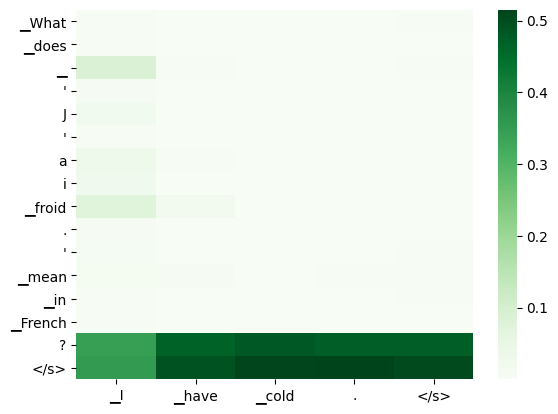

44


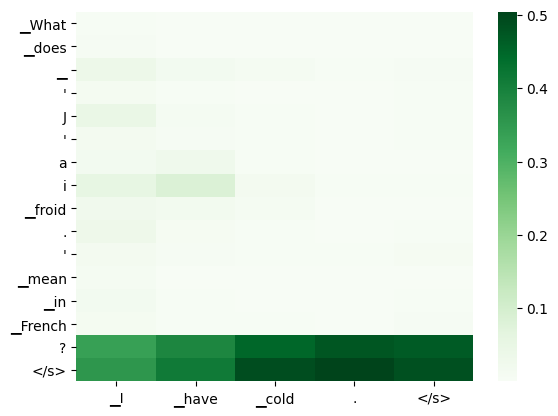

45


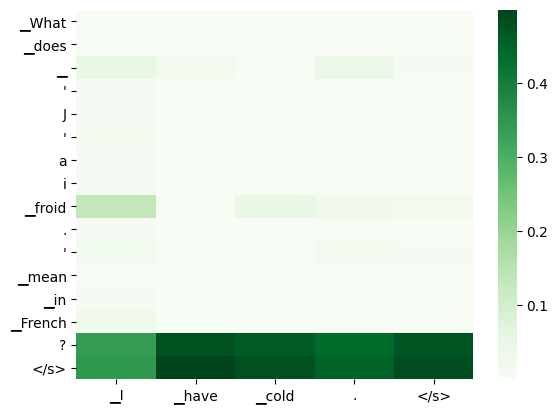

46


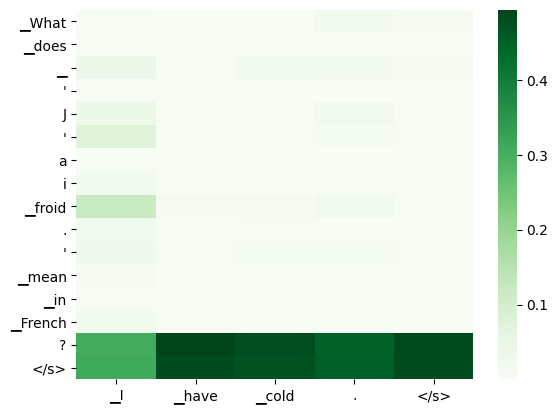

47


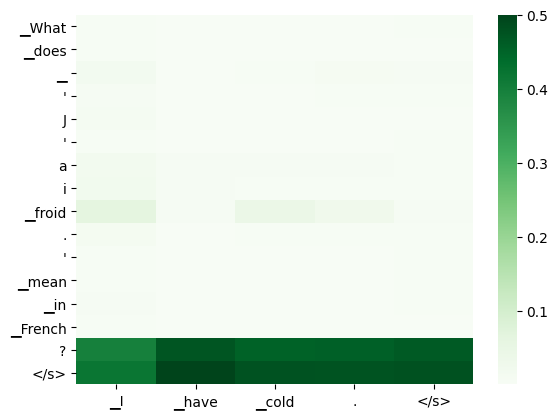

48


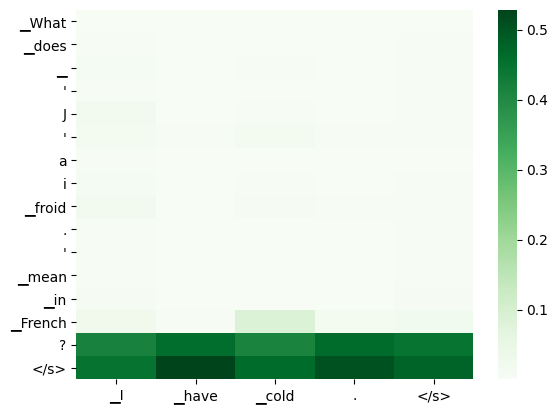

49


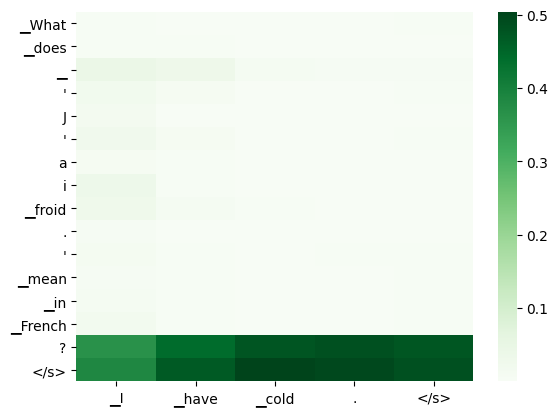

50


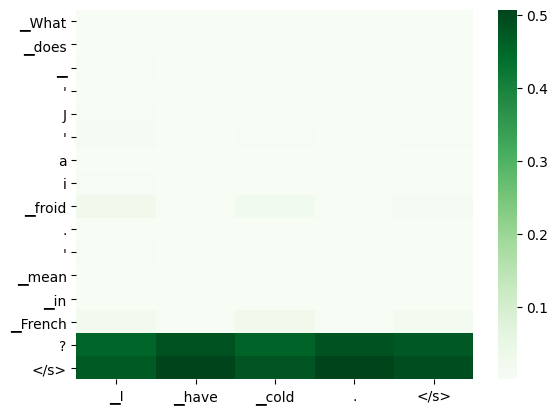

51


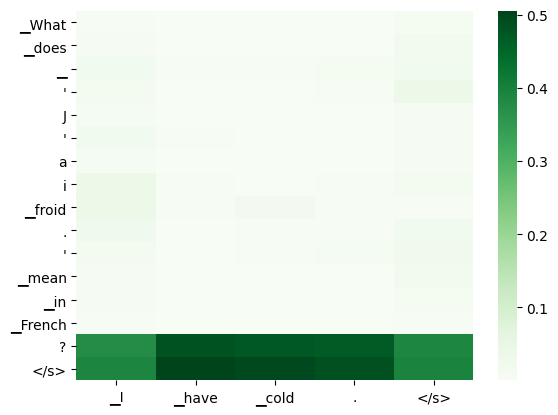

52


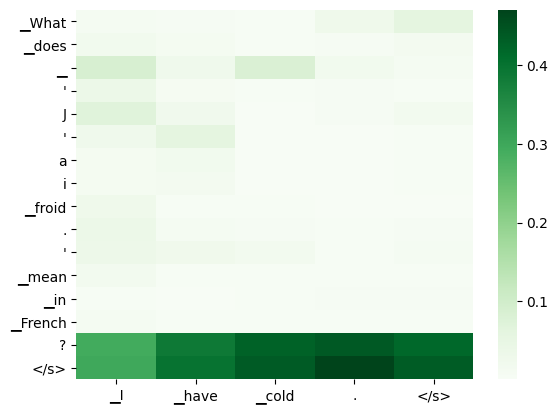

53


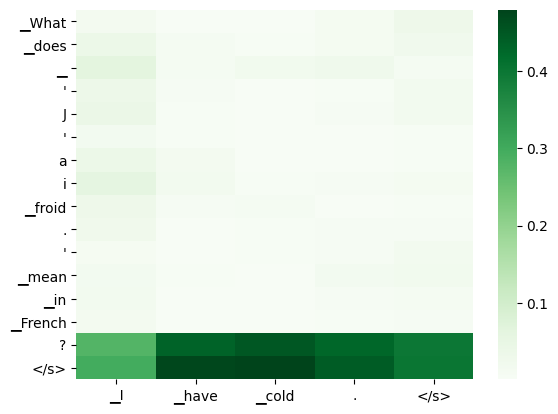

54


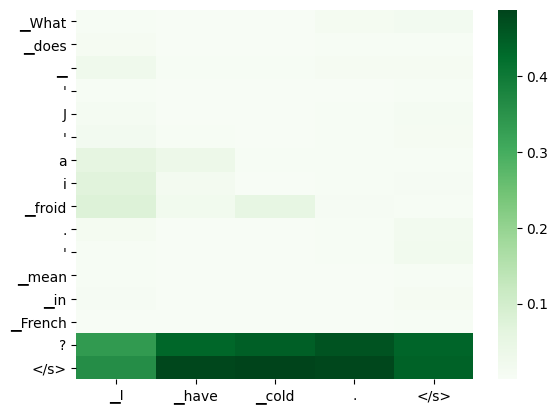

55


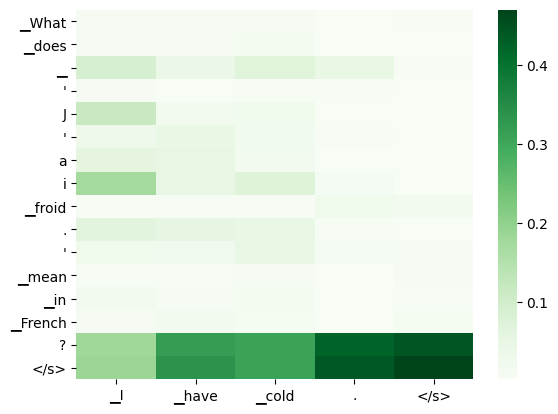

56


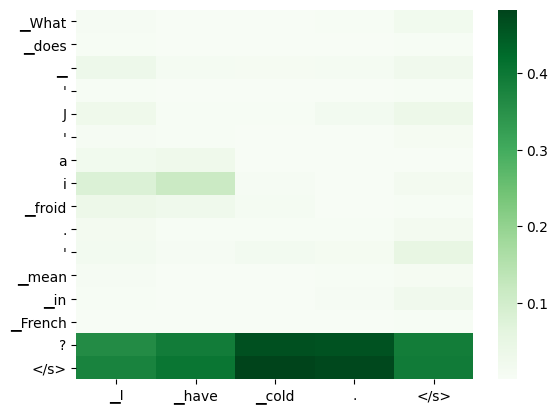

57


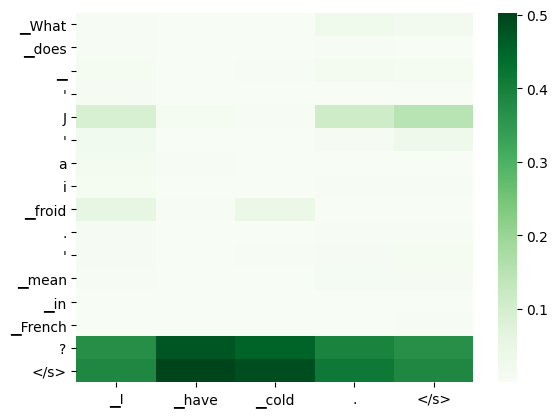

58


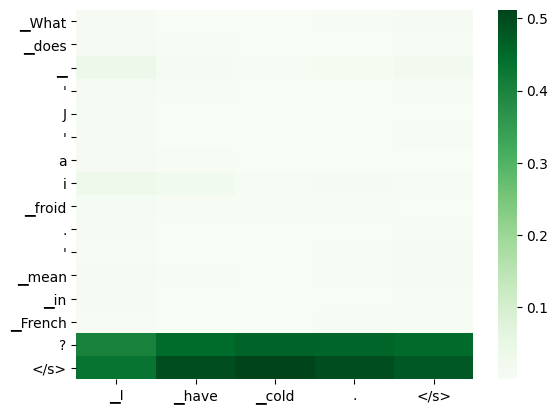

59


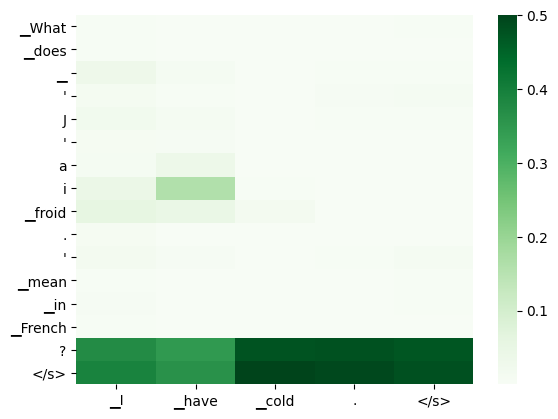

60


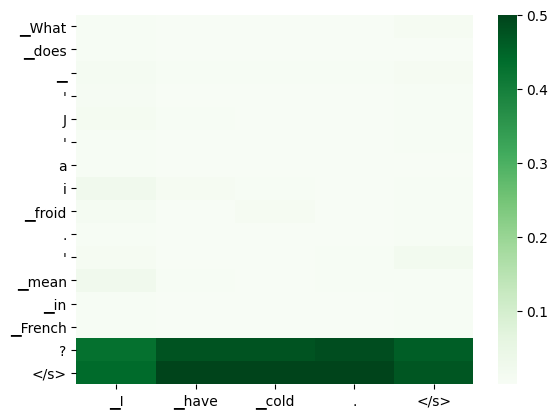

61


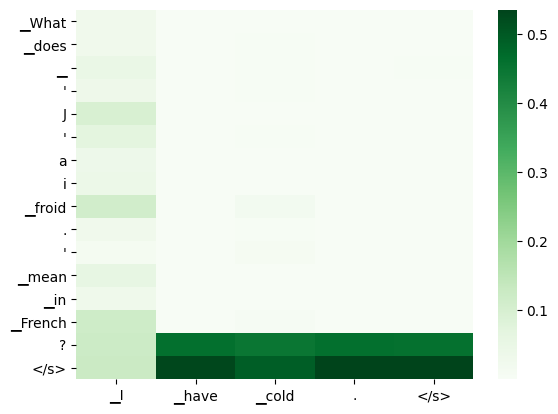

62


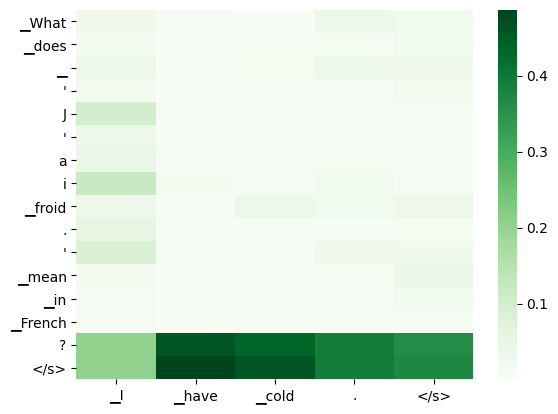

63


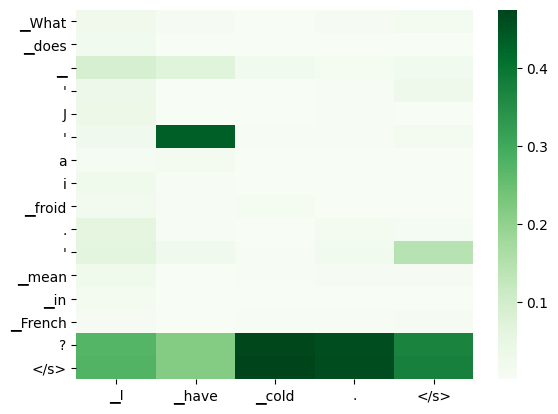

In [118]:
for i in range(64):
    print(i)
    lines = ()
    for j in range(len(cross_attn)):
        line = cross_attn[j][23][0, i, 0, :]
        lines = lines + (line.unsqueeze(1),)
    matrix = torch.cat(lines, dim=1)
    #matrix = matrix.permute(1,0)
    matrix = matrix.cpu()
    sns.heatmap(matrix, 
            cmap="Greens",
            xticklabels = out_seq[1:],
            yticklabels = src_seq)
    plt.show()

# Two Sentences

In [4]:
names_1 = ["John", "Harry", "Andrew", "Lisa", "Mary"]
names_2 = ["Henry", "David", "Sophia", "Olivia", "Emma"]

cities_1 = ["London", "Paris", "Oslo", "Istanbul", "Beijing"]
cities_2 = ["Sydney", "Cairo", "Seoul", "Rome", "Prague"]

class DataSample_TwoSentences():
    def __init__(self, name_1, name_2, city_1, city_2):
        self.name_1 = name_1
        self.name_2 = name_2
        self.city_1 = city_1
        self.city_2 = city_2
        self.context_1 = name_1 + " travelled to " + city_1 + ". " + name_2 + " travelled to " + city_2 + ". Where did " + name_1 + " travel to?"
        self.context_2 = name_1 + " travelled to " + city_1 + ". " + name_2 + " travelled to " + city_2 + ". Where did " + name_2 + " travel to?"
        
class TwoSentenceResults():
    def __init__(self, prompt, context, question, probability_correct, probability_wrong):
        self.prompt = prompt
        self.context = context
        self.question = question
        self.probability_correct = probability_correct
        self.probability_wrong = probability_wrong
        
data_points_two_sentences = []
for name_1 in names_1:
    for name_2 in names_2:
        for city_1 in cities_1:
            for city_2 in cities_2:
                sample = DataSample_TwoSentences(name_1, name_2, city_1, city_2)
                data_points_two_sentences.append(sample)

In [7]:
sample = data_points_two_sentences[0]

context_1 = sample.context_1
context_2 = sample.context_2
city_1 = sample.city_1
city_2 = sample.city_2

input_ids = tokenizer.encode(context_1, return_tensors="pt").to(device)
model_output = model.generate(input_ids, max_new_tokens=1, output_scores=True, return_dict_in_generate=True)

out_decoded = tokenizer.decode(model_output.sequences[0])

src_seq = tokenizer.tokenize(context_1, add_special_tokens=True)
out_seq = tokenizer.tokenize(out_decoded)

enc_attn = model_output.encoder_attentions
dec_attn = model_output.decoder_attentions
cross_attn = model_output.cross_attentions

In [9]:
print(out_decoded)
print(src_seq)
print(out_seq)

<pad> London
['▁John', '▁', 'travelled', '▁to', '▁London', '.', '▁Henry', '▁', 'travelled', '▁to', '▁Sydney', '.', '▁Where', '▁did', '▁John', '▁travel', '▁to', '?', '</s>']
['<pad>', '▁London']


In [13]:
cross_attn[0][0].shape

torch.Size([1, 64, 1, 19])

In [16]:
num_keys = cross_attn[0][23].shape[-1]

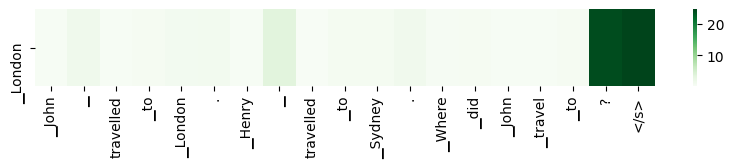

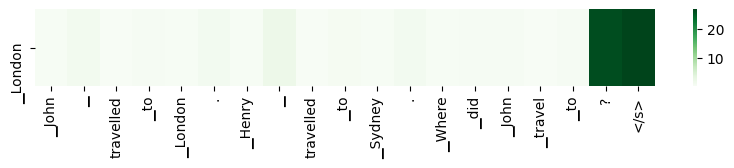

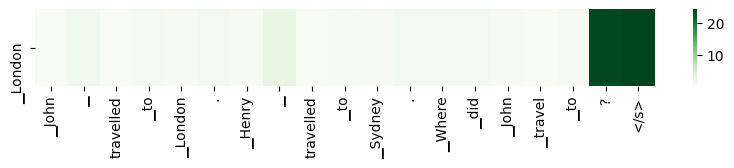

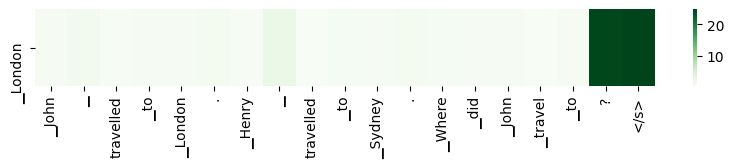

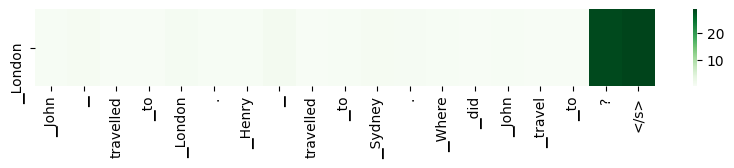

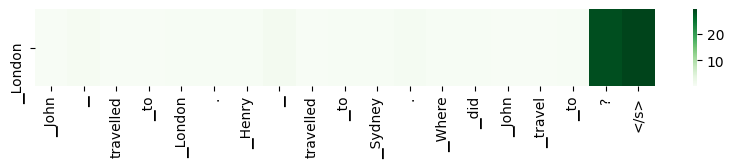

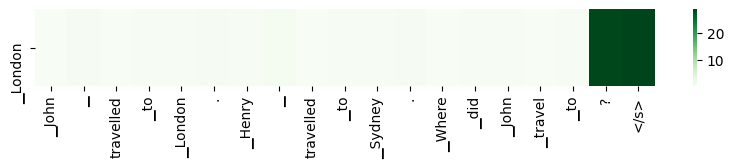

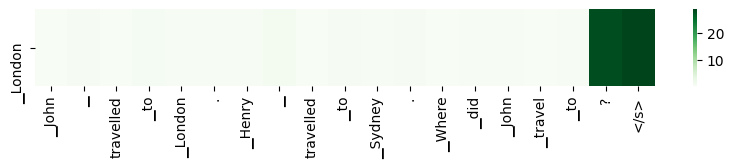

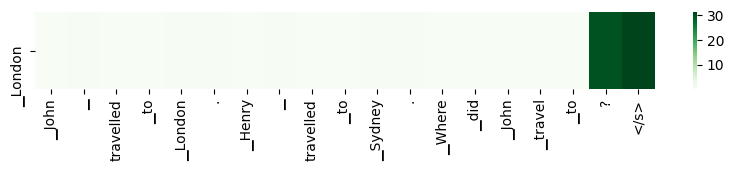

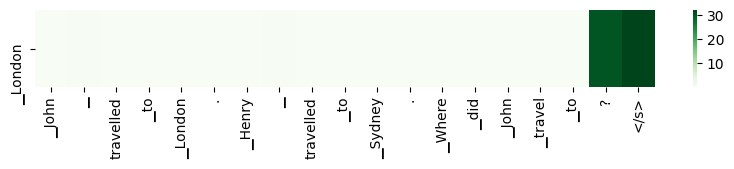

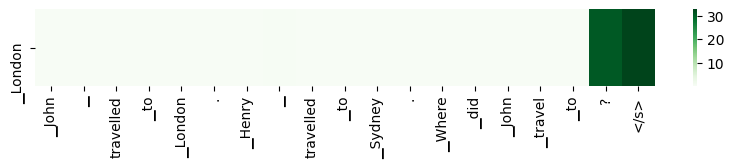

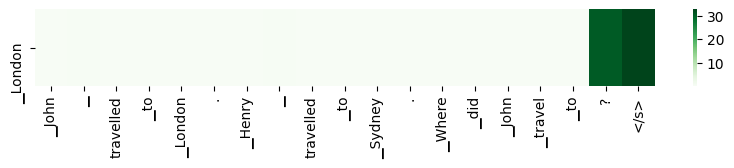

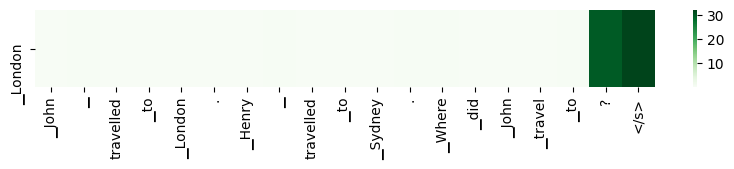

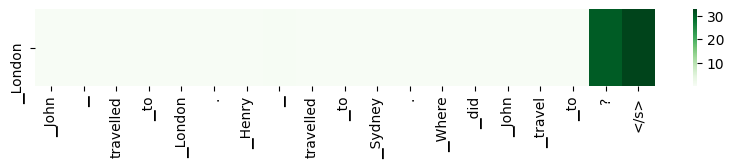

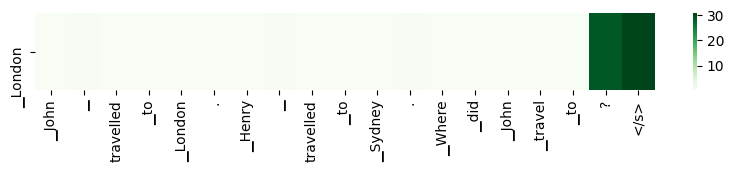

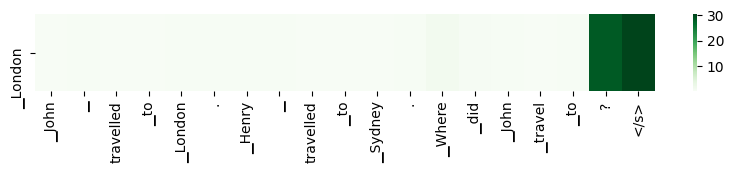

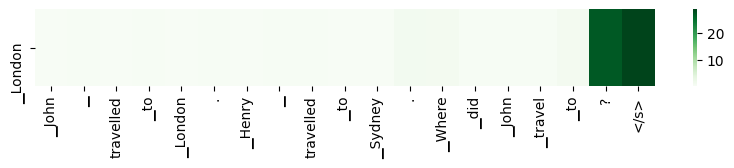

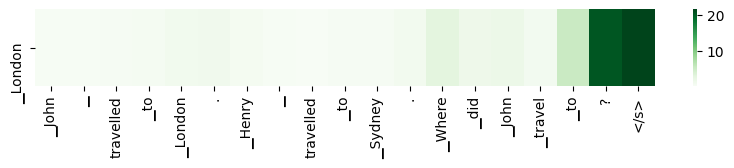

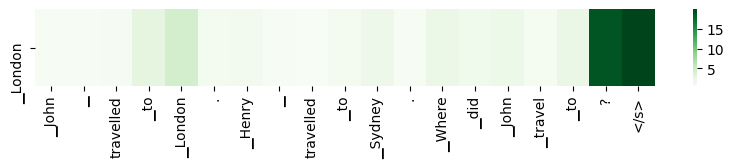

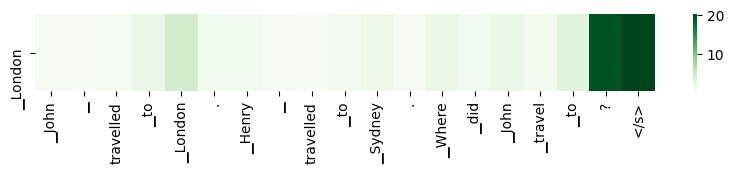

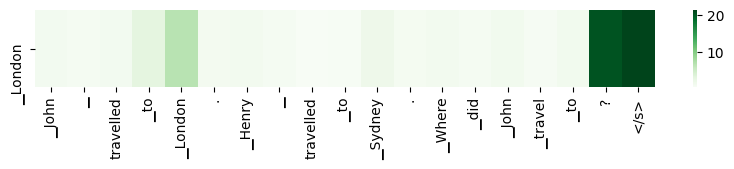

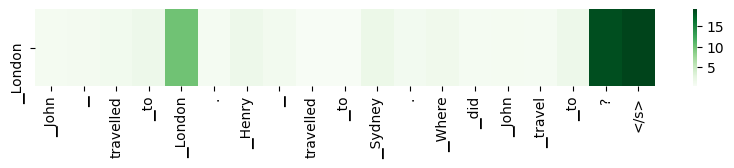

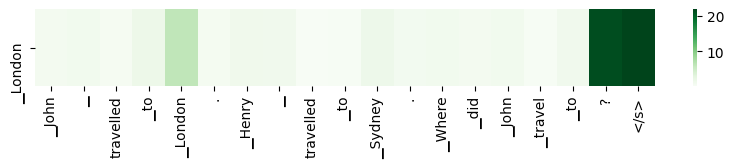

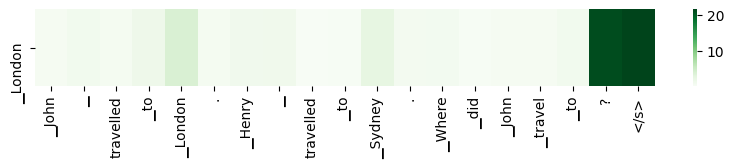

In [20]:
for layer in range(num_layers):
    attn_sum = torch.zeros(num_keys).to(device)
    for i in range(64):
        line = cross_attn[-1][layer][0, i, 0, :].to(device)
        attn_sum += line
        #matrix = matrix.permute(1,0)
    attn_sum = attn_sum.cpu()
    fig, ax = plt.subplots(figsize=(10,1)) 
    sns.heatmap(attn_sum.unsqueeze(0), 
            cmap="Greens",
            ax=ax,
            #annot=True,
            xticklabels = src_seq,
            yticklabels = out_seq[1:])

    plt.show()

In [38]:
attn_sum = torch.zeros(num_keys).to(device)
for layer in range(num_layers):
    
    for i in range(64):
        line = cross_attn[-1][layer][0, i, 0, :].to(device)
        attn_sum += line


In [28]:
1536/64

24.0

In [29]:
attn_sum = attn_sum / 1536

In [30]:
attn_sum

tensor([0.0058, 0.0106, 0.0061, 0.0125, 0.0279, 0.0095, 0.0088, 0.0156, 0.0032,
        0.0065, 0.0115, 0.0103, 0.0123, 0.0085, 0.0095, 0.0054, 0.0145, 0.4014,
        0.4202])

In [43]:
x = attn_sum[:-2] / sum(attn_sum[:-2])

In [44]:
x

tensor([0.0326, 0.0594, 0.0343, 0.0699, 0.1562, 0.0534, 0.0494, 0.0872, 0.0180,
        0.0362, 0.0646, 0.0578, 0.0689, 0.0477, 0.0530, 0.0304, 0.0812])

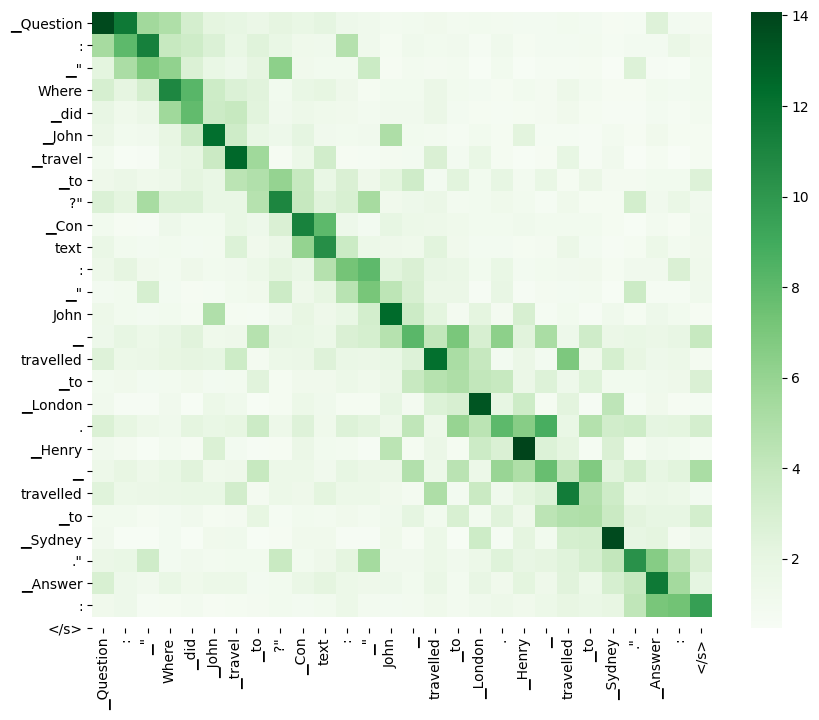

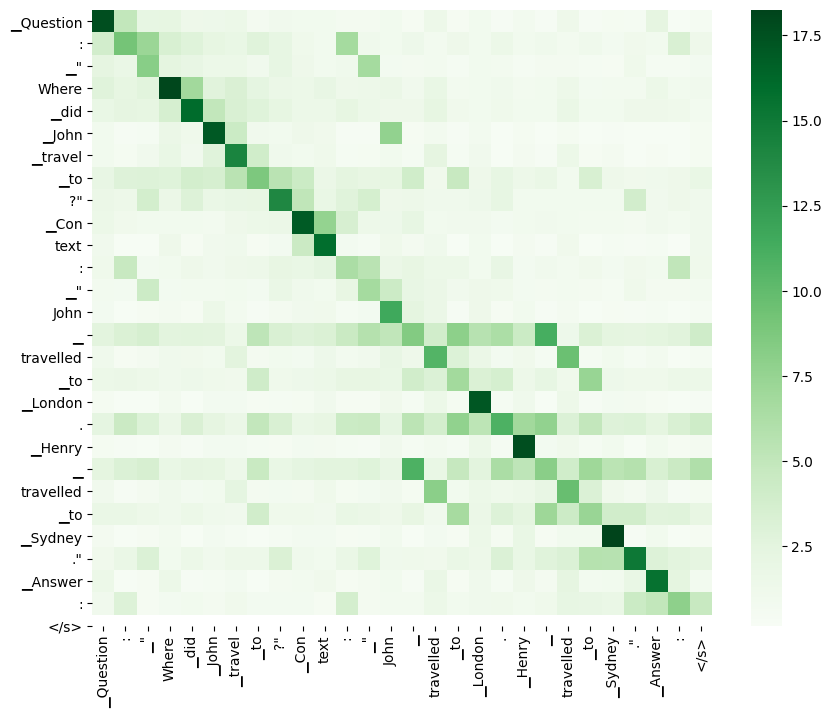

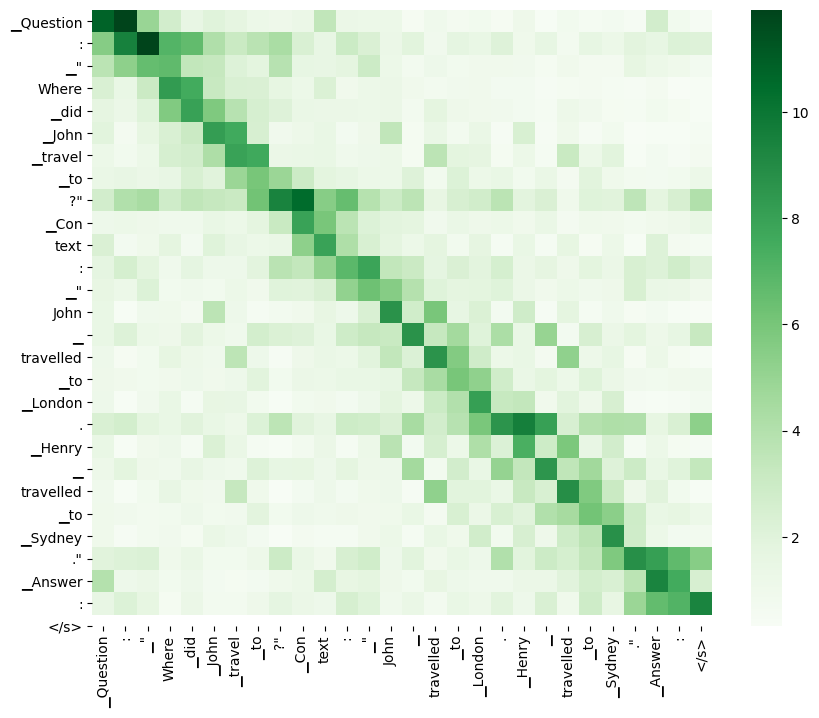

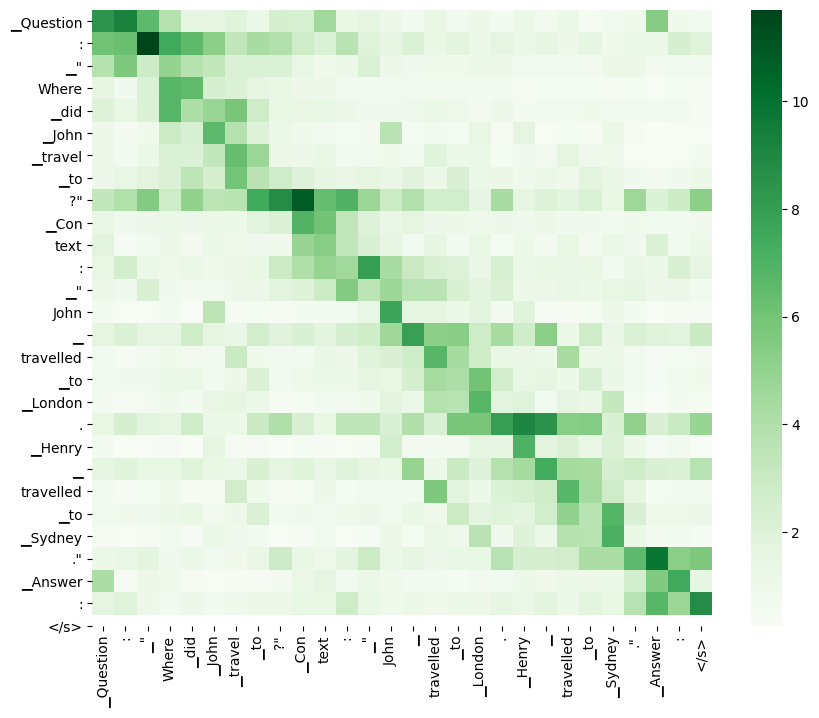

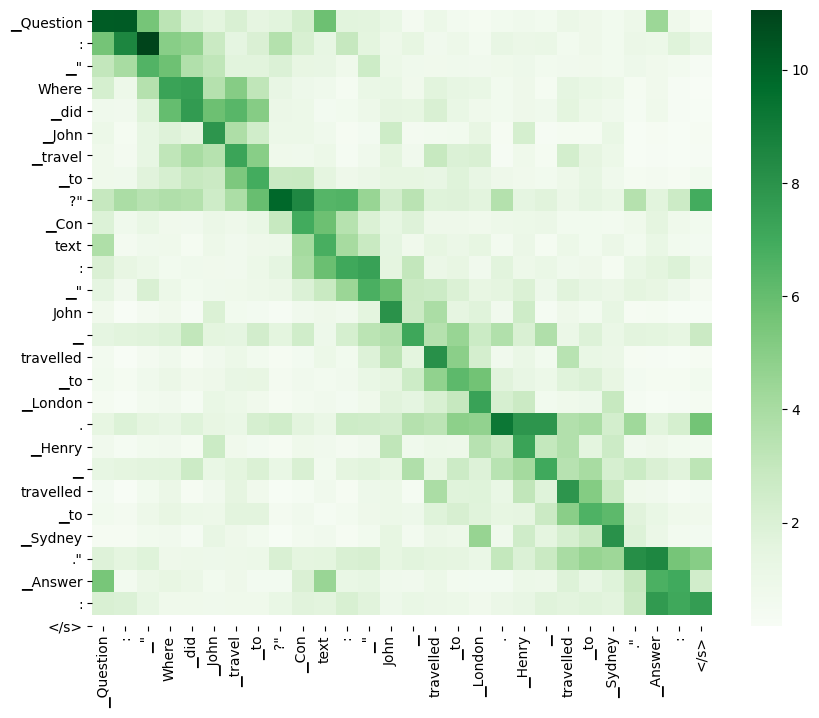

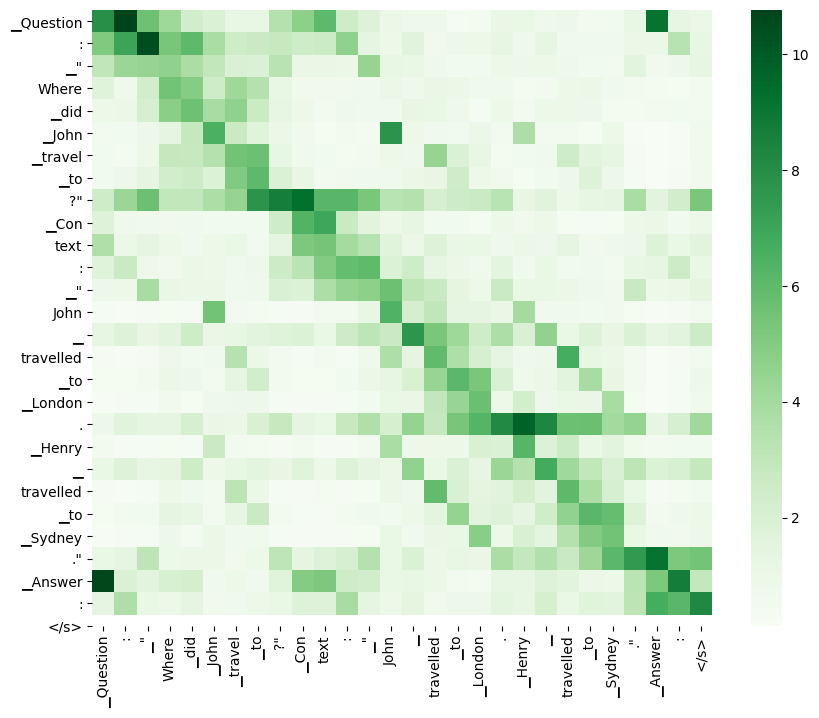

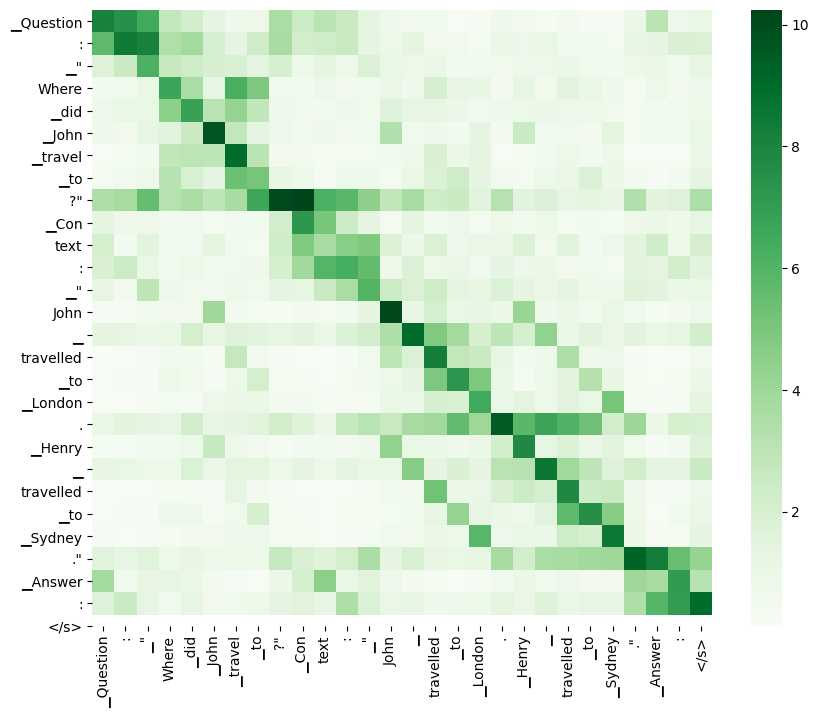

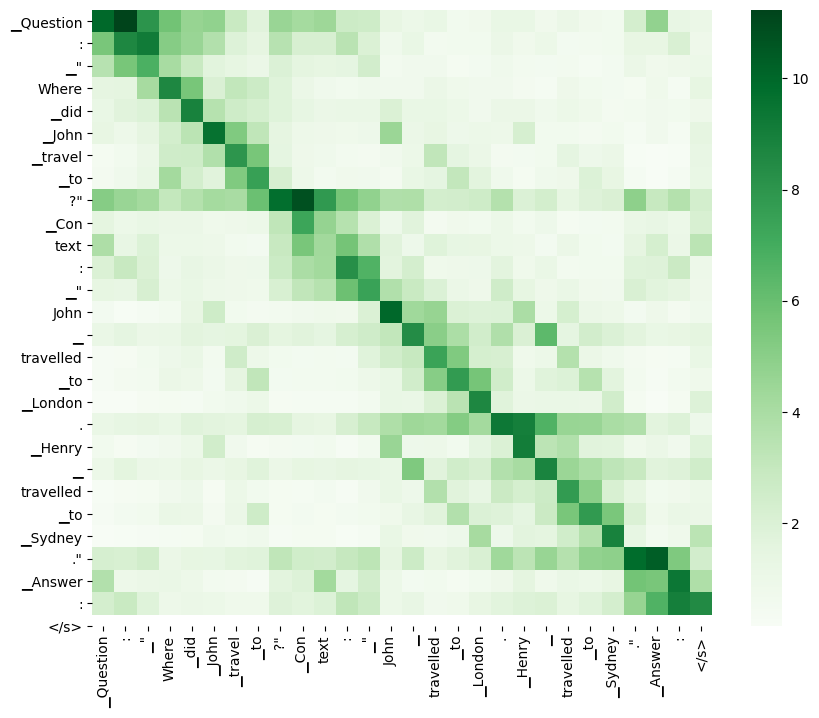

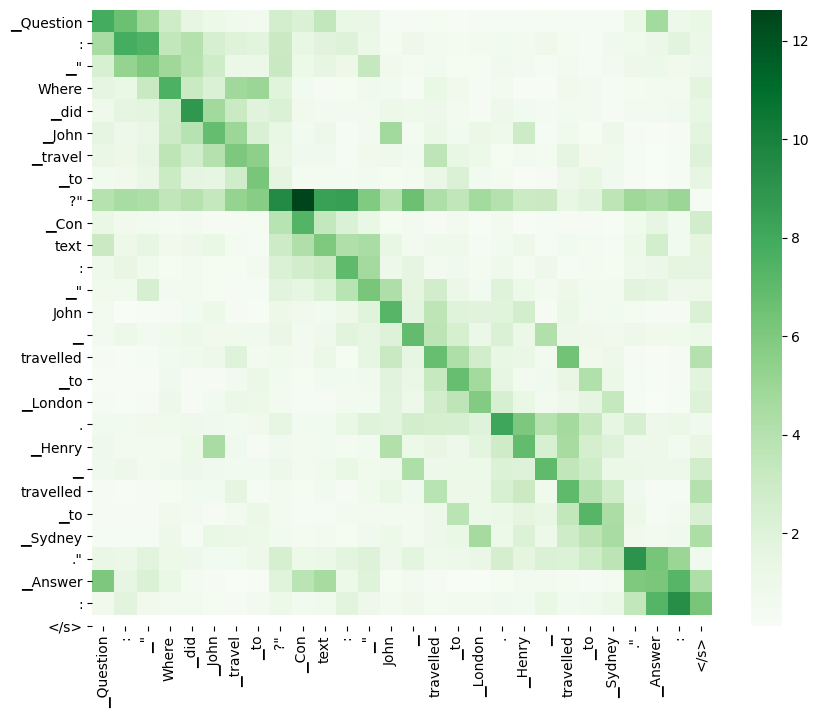

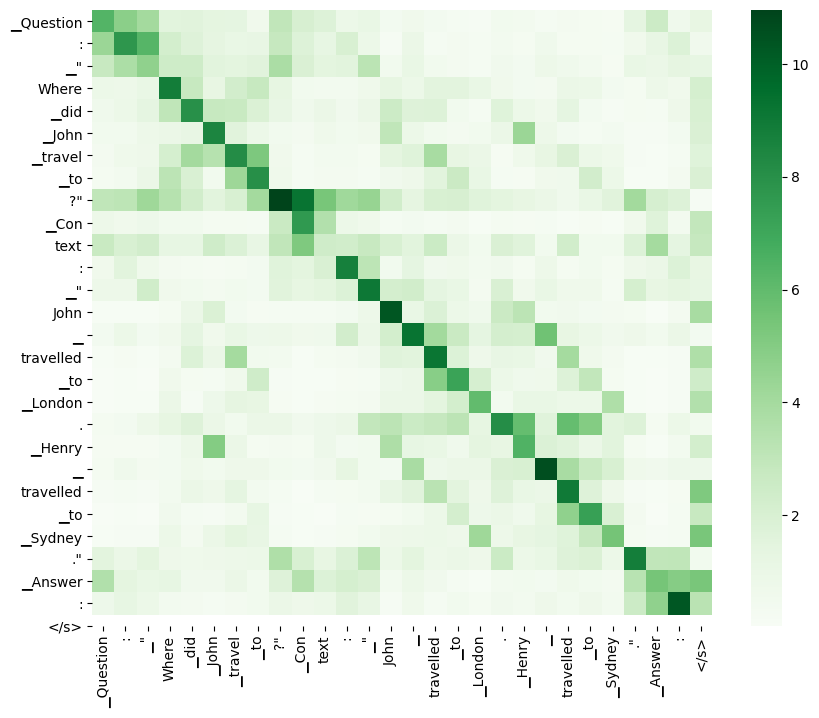

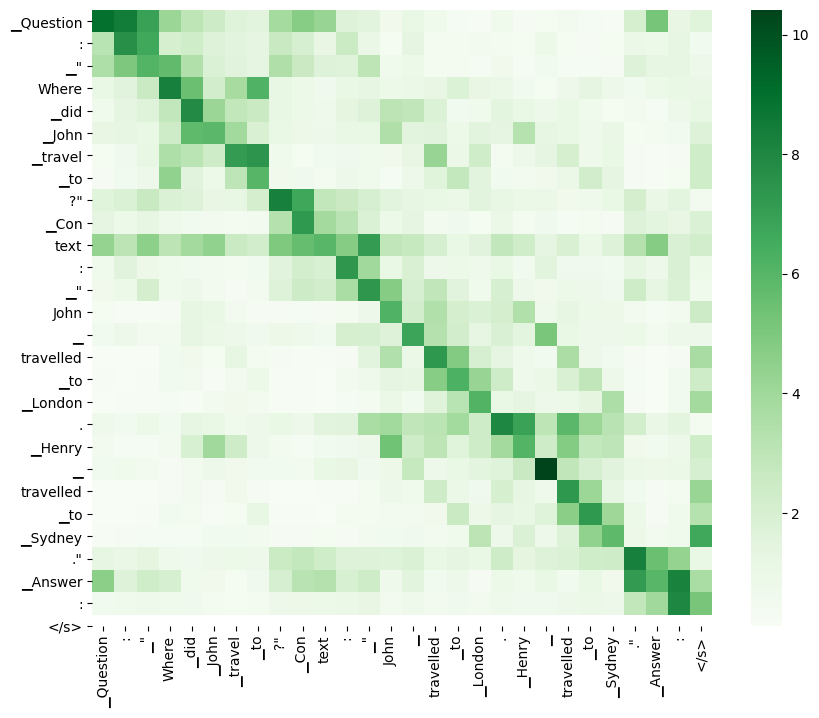

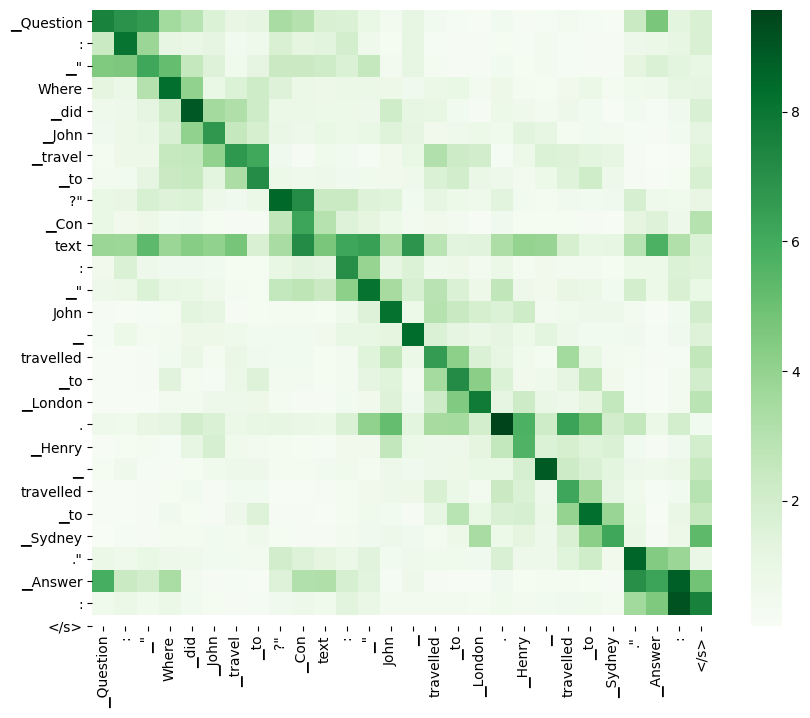

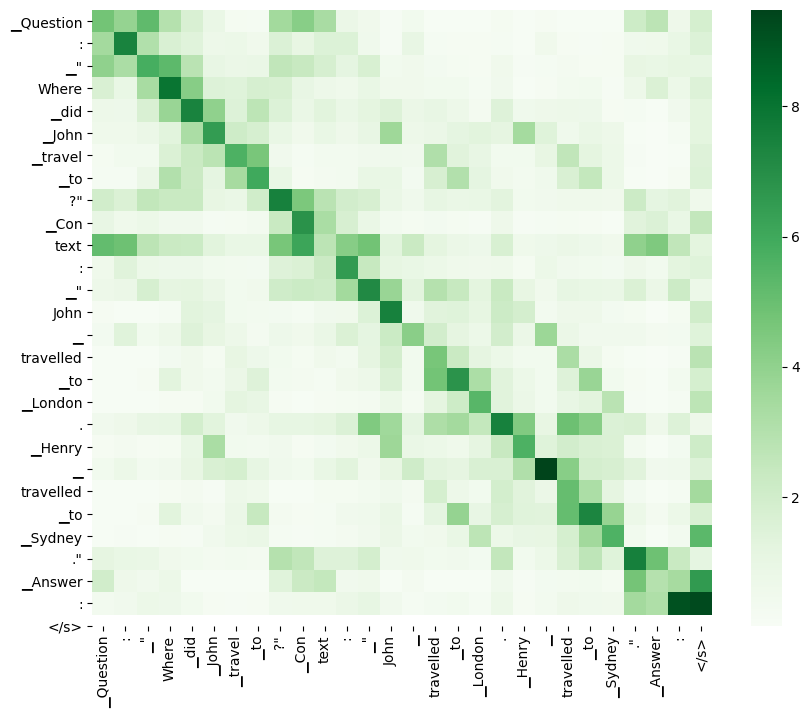

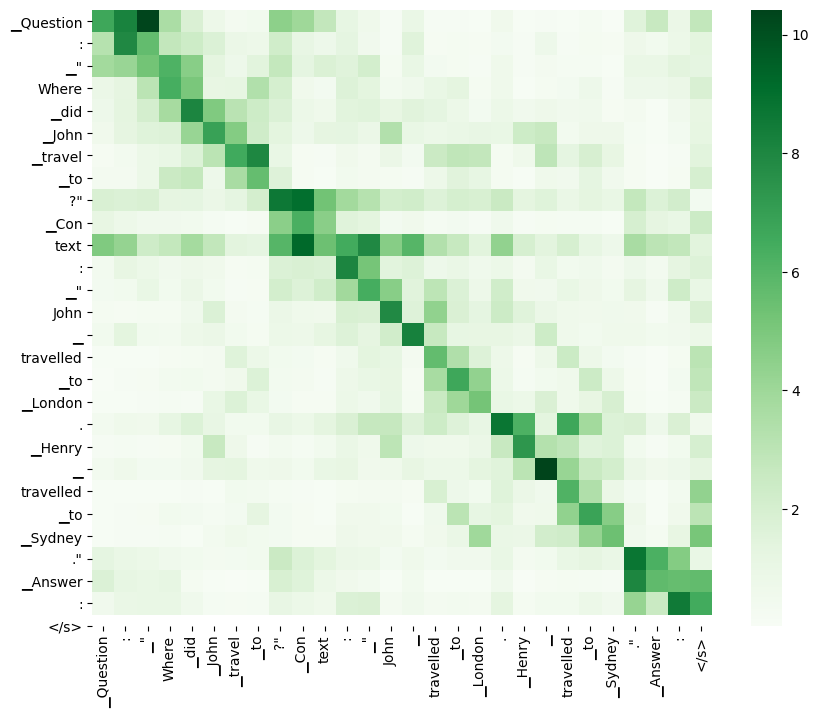

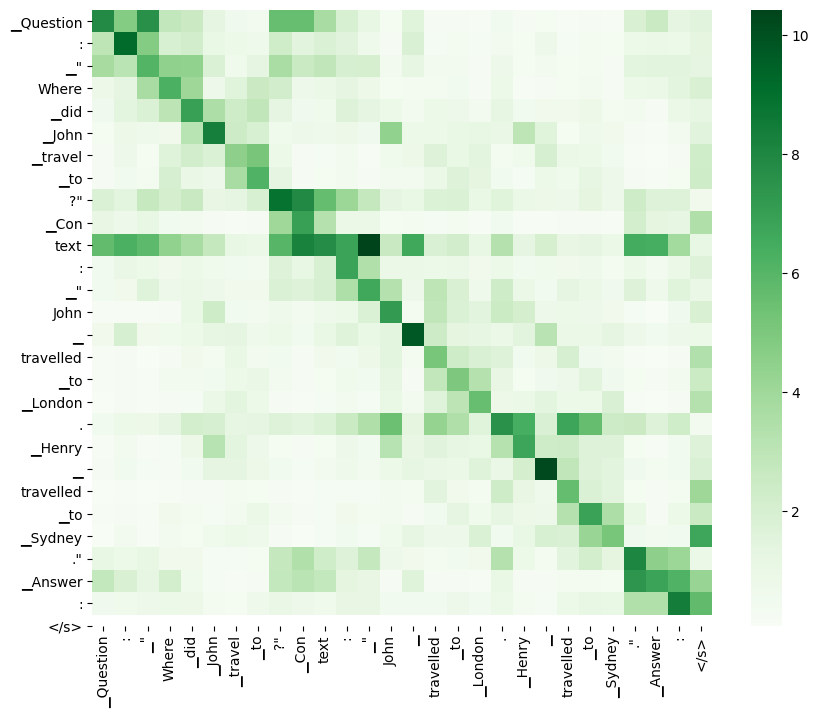

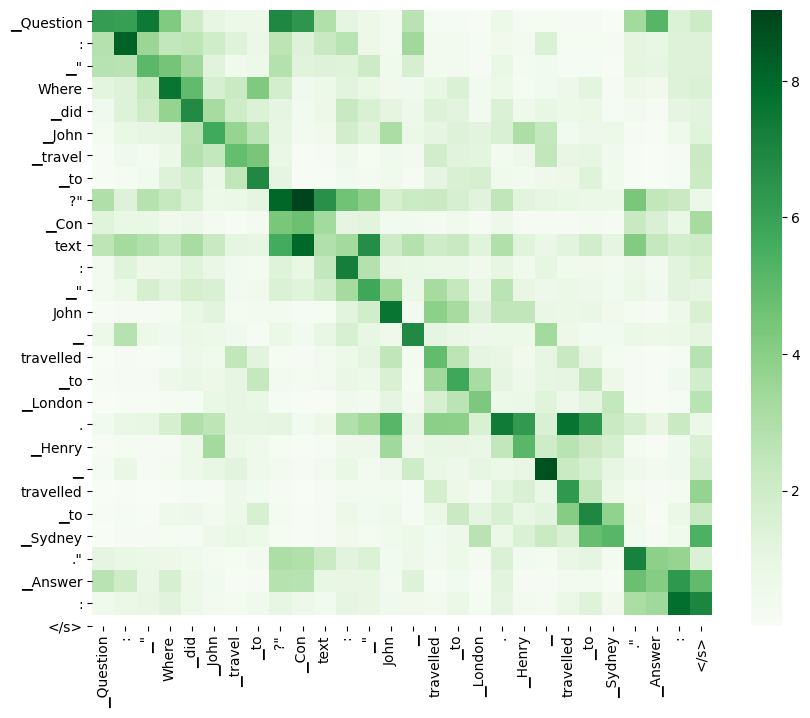

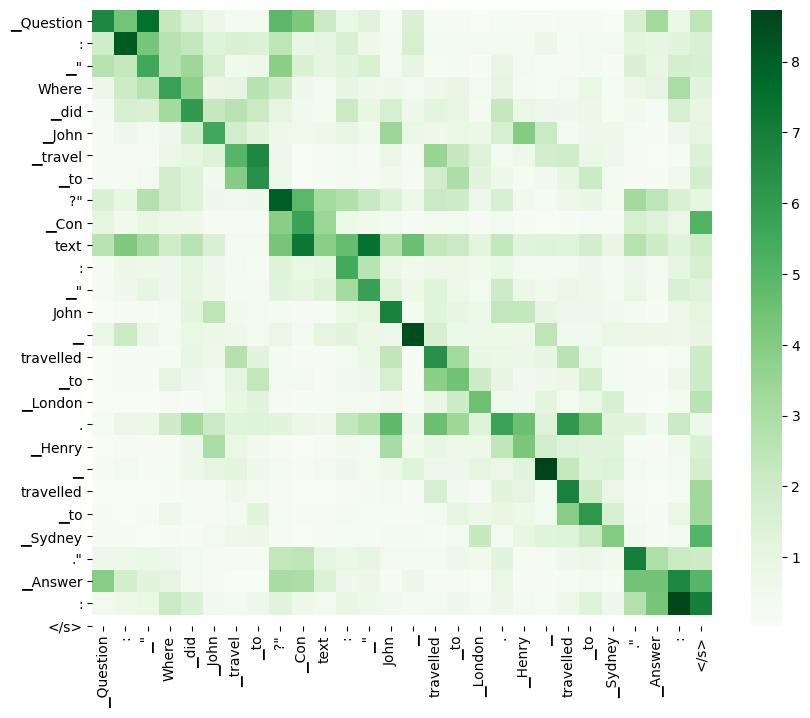

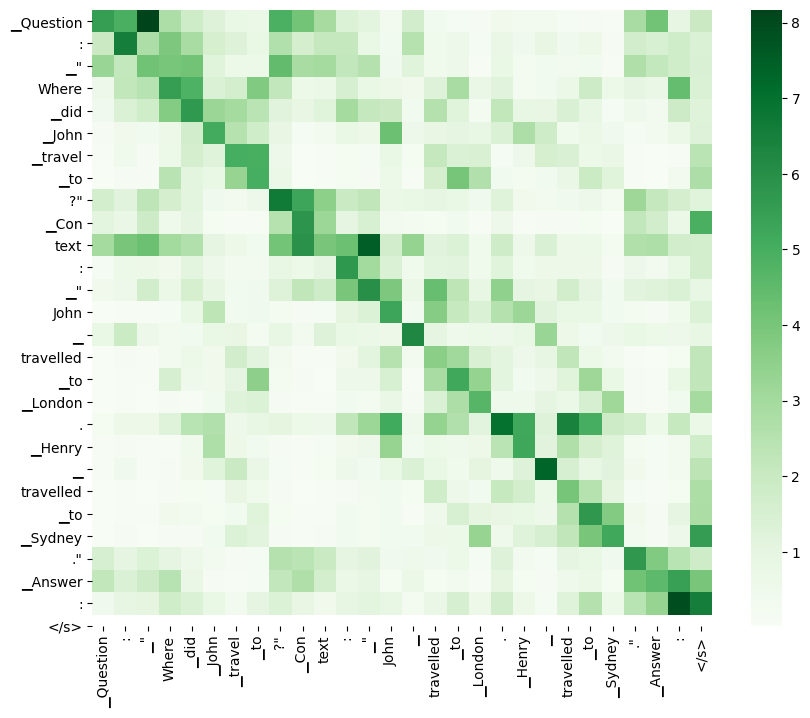

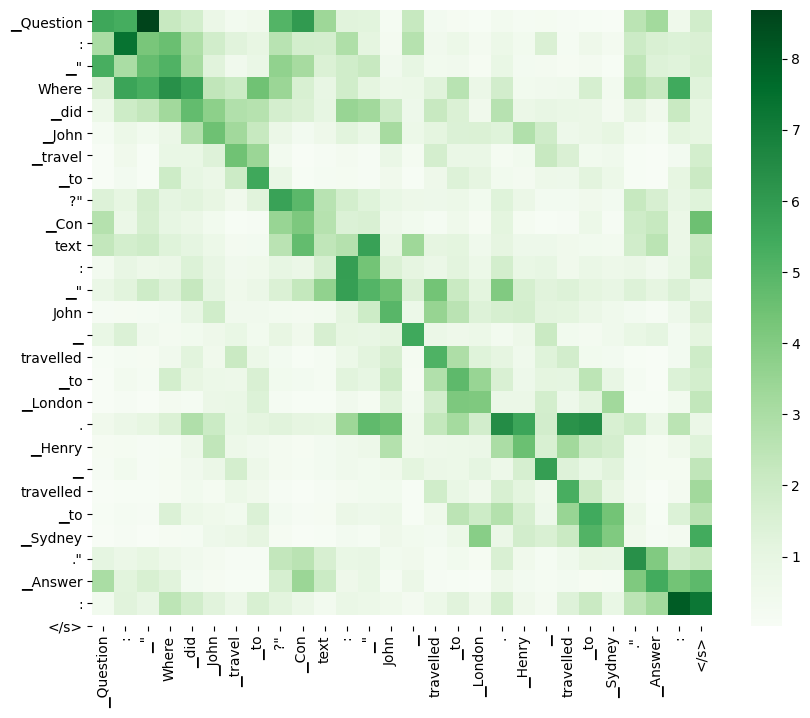

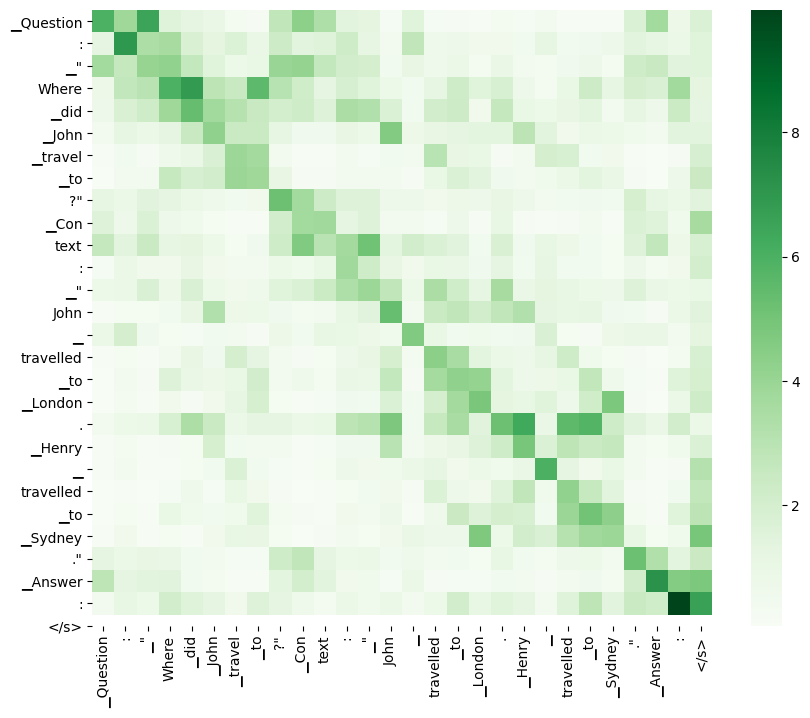

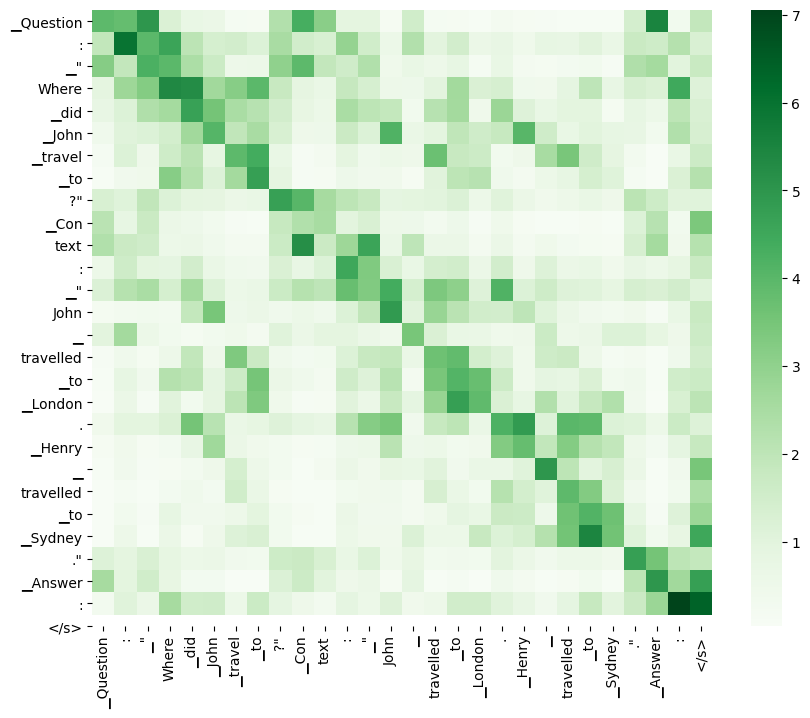

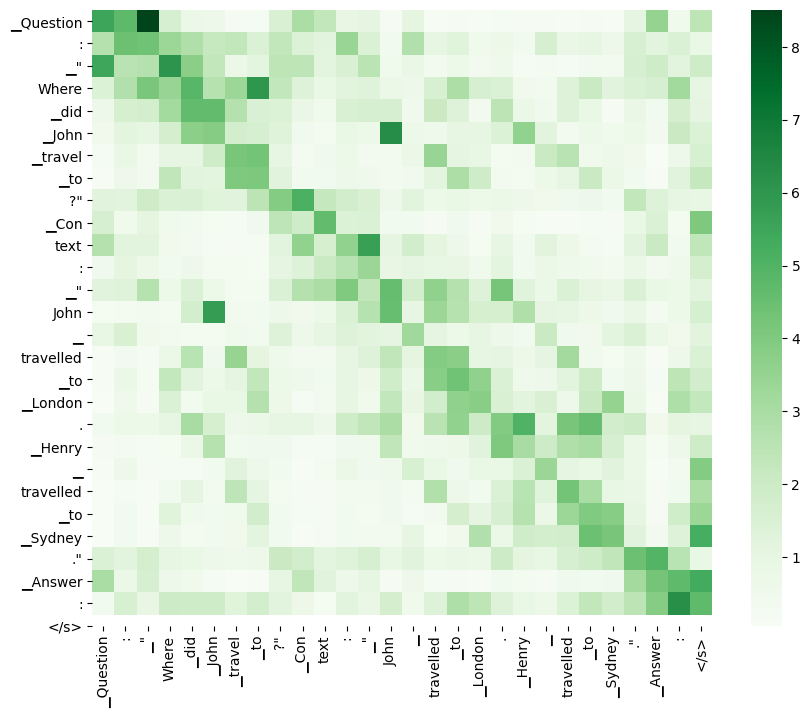

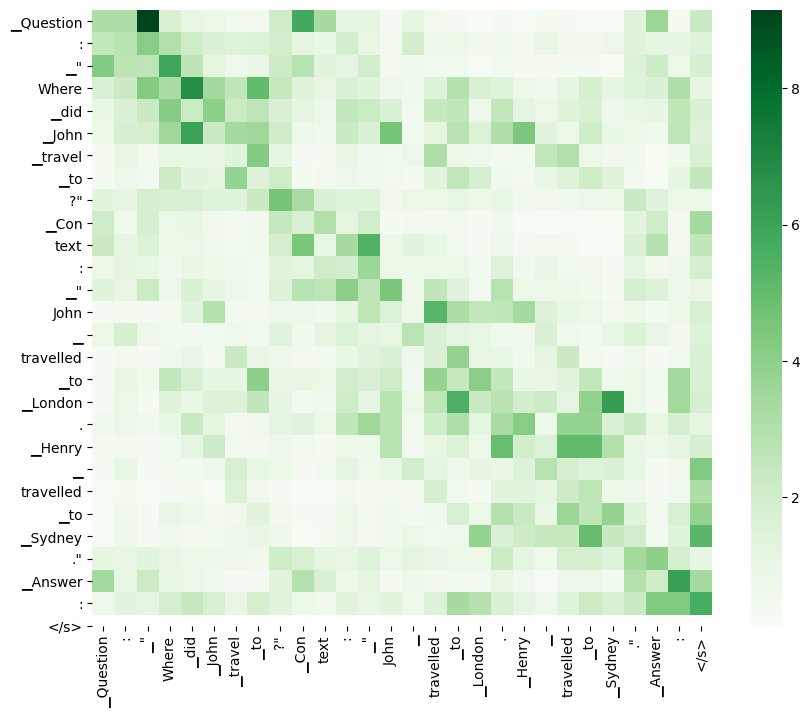

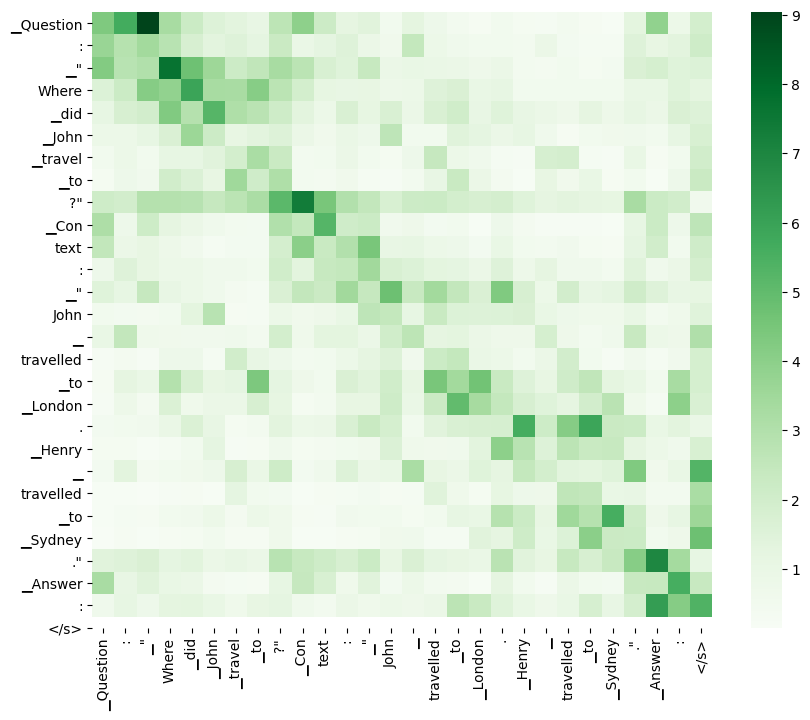

In [168]:
for layer in range(num_layers):
    attn_sum = torch.zeros(num_keys,num_keys).to(device)
    for i in range(64):
        line = enc_attn[layer][0, i, :, :].to(device)
        line = line.permute(1,0)
        attn_sum += line
    attn_sum = attn_sum.cpu()
    fig, ax = plt.subplots(figsize=(10,8)) 
    sns.heatmap(attn_sum[:-1,:], 
            cmap="Greens",
            ax=ax,
            xticklabels = src_seq,
            yticklabels = src_seq)
    plt.show()

In [151]:
attn_sum

tensor([ 0.3915,  0.6106,  0.3832,  0.8710,  0.6426,  0.9110,  1.1642,  0.7840,
         2.4318,  0.9196,  0.8382,  0.5441,  1.4917,  1.5360,  0.9938,  1.4076,
         1.2862,  5.1530,  1.4553,  3.0977,  2.5160,  0.8392,  0.4506,  4.9535,
         2.4615,  0.5307,  1.0563, 24.2789])

# Three Sentences

In [5]:
names_1 = ["John", "Harry", "Andrew"]
names_2 = ["Henry", "David", "Sophia"]
names_3 = ["Olivia", "Emma", "Lisa"]

cities_1 = ["London", "Paris", "Oslo"]
cities_2 = ["Sydney", "Cairo", "Seoul"]
cities_3 = ["Istanbul", "Beijing", "Rome"]

class DataSample_ThreeSentences():
    def __init__(self, name_1, name_2, name_3, city_1, city_2, city_3):
        self.name_1 = name_1
        self.name_2 = name_2
        self.name_3 = name_3
        self.city_1 = city_1
        self.city_2 = city_2
        self.city_3 = city_3
        self.context = name_1 + " travelled to " + city_1 + ". " + name_2 + " travelled to " + city_2 + ". " + name_3 + " travelled to " + city_3 + "."
        self.question_1 = "Where did " + name_1 + " travel to?"
        self.question_2 = "Where did " + name_2 + " travel to?"
        self.question_3 = "Where did " + name_3 + " travel to?"
        self.prompt_1 = self.context + " " + self.question_1
        self.prompt_2 = self.context + " " + self.question_2
        self.prompt_3 = self.context + " " + self.question_3
        self.answer_1 = city_1
        self.answer_2 = city_2
        self.answer_3 = city_3

data_points_three_sentences = []
for name_1 in names_1:
    for name_2 in names_2:
        for name_3 in names_3:
            for city_1 in cities_1:
                for city_2 in cities_2:
                    for city_3 in cities_3:
                        sample = DataSample_ThreeSentences(name_1, name_2, name_3, city_1, city_2, city_3)
                        data_points_three_sentences.append(sample)

In [7]:
sample = data_points_three_sentences[0]

context_1 = sample.prompt_1
context_2 = sample.prompt_2
context_3 = sample.prompt_3
city_1 = sample.city_1
city_2 = sample.city_2
city_3 = sample.city_3

input_ids = tokenizer.encode(context_1, return_tensors="pt").to(device)
model_output = model.generate(input_ids, max_new_tokens=1, output_scores=True, return_dict_in_generate=True)

out_decoded = tokenizer.decode(model_output.sequences[0])

src_seq = tokenizer.tokenize(context_1, add_special_tokens=True)
out_seq = tokenizer.tokenize(out_decoded)

enc_attn = model_output.encoder_attentions
dec_attn = model_output.decoder_attentions
cross_attn = model_output.cross_attentions

In [9]:
print(context_1)
print(city_1)
print(out_decoded)
print(src_seq)
print(out_seq)

John travelled to London. Henry travelled to Sydney. Olivia travelled to Istanbul. Where did John travel to?
London
<pad> London
['▁John', '▁', 'travelled', '▁to', '▁London', '.', '▁Henry', '▁', 'travelled', '▁to', '▁Sydney', '.', '▁Olivia', '▁', 'travelled', '▁to', '▁Istanbul', '.', '▁Where', '▁did', '▁John', '▁travel', '▁to', '?', '</s>']
['<pad>', '▁London']


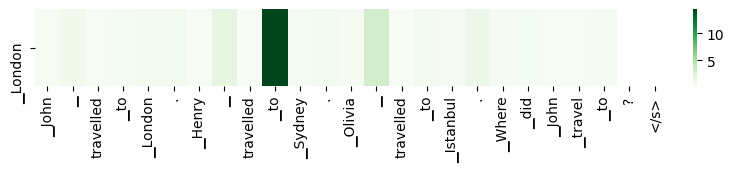

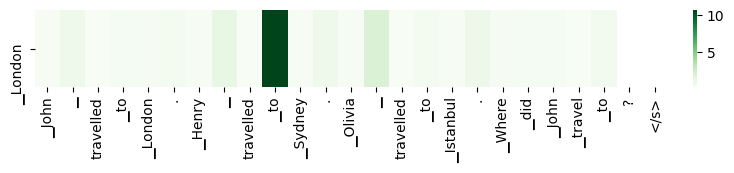

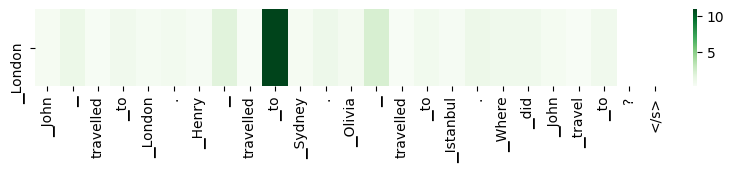

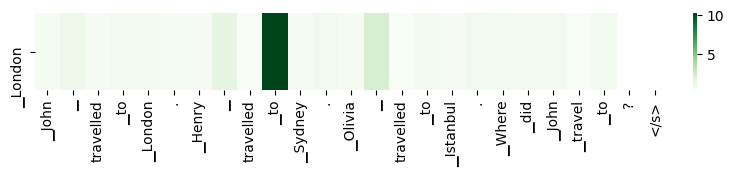

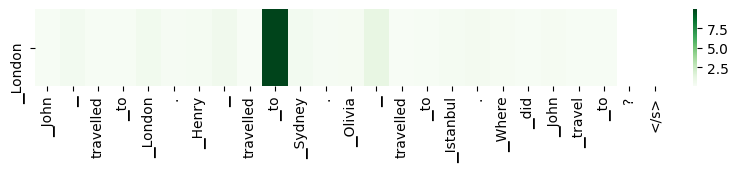

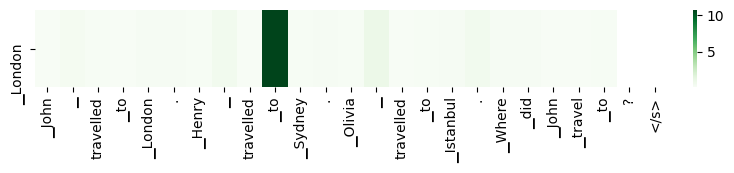

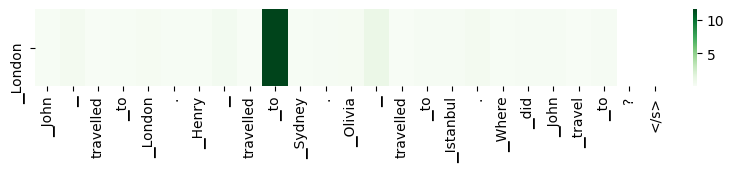

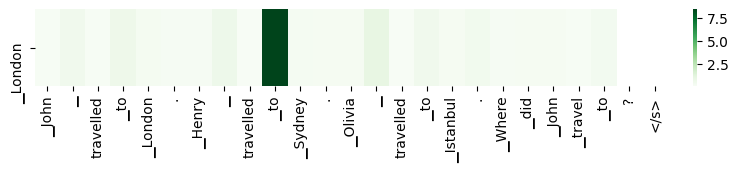

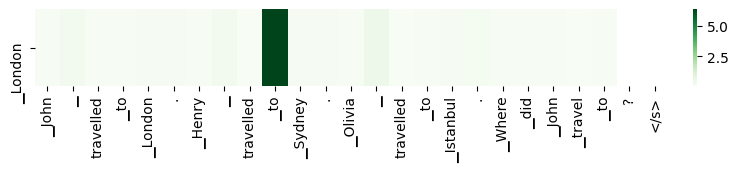

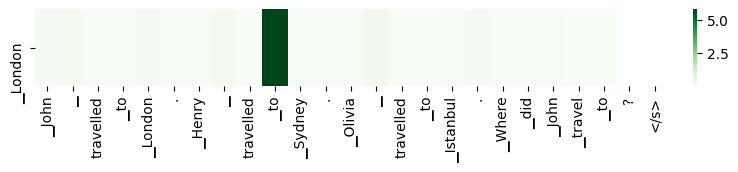

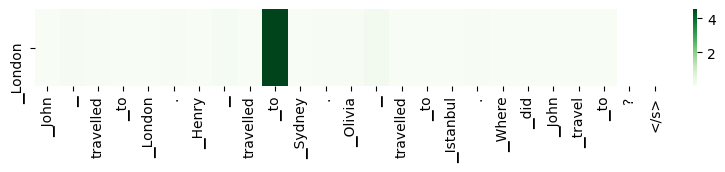

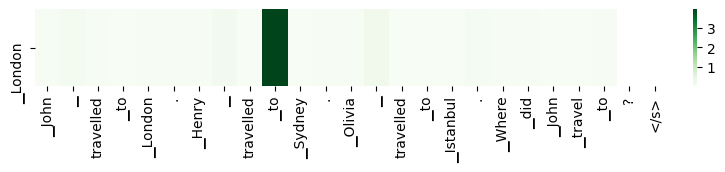

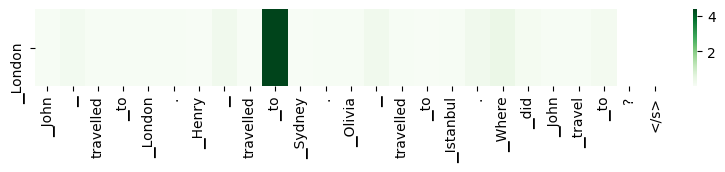

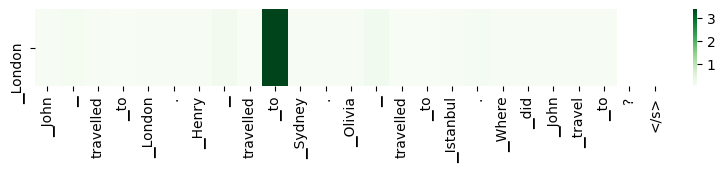

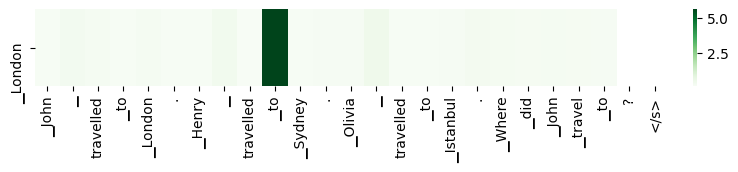

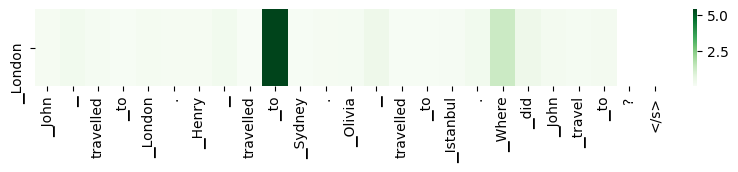

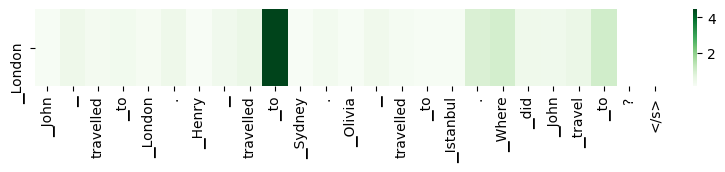

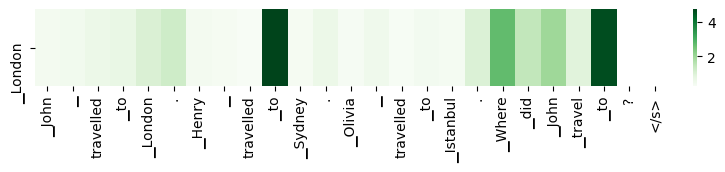

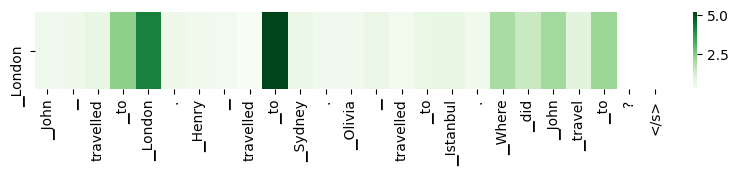

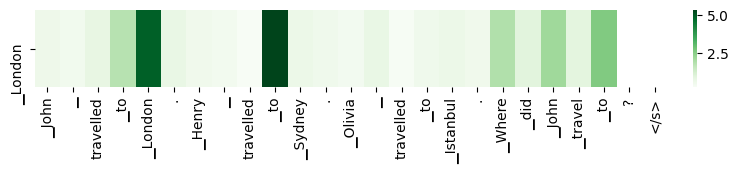

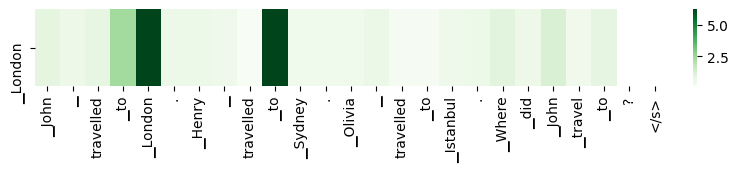

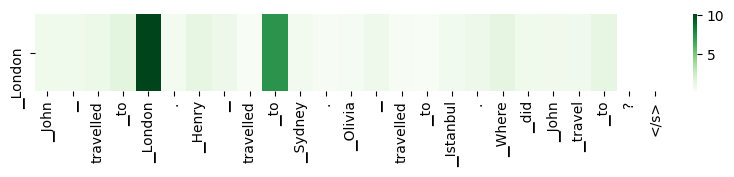

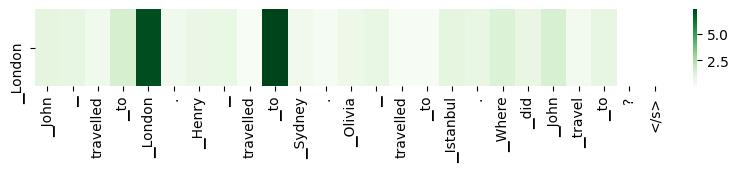

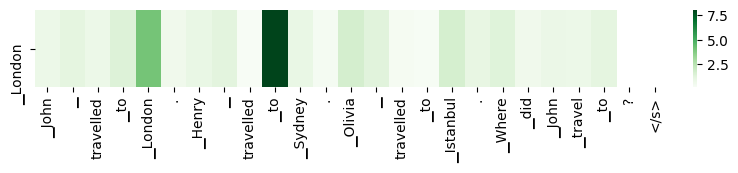

In [14]:
num_keys = cross_attn[0][23].shape[-1]

for layer in range(num_layers):
    attn_sum = torch.zeros(num_keys-2).to(device)
    for i in range(64):
        line = cross_attn[-1][layer][0, i, 0, :-2].to(device)
        attn_sum += line
        #matrix = matrix.permute(1,0)
    attn_sum = attn_sum.cpu()
    fig, ax = plt.subplots(figsize=(10,1)) 
    sns.heatmap(attn_sum.unsqueeze(0), 
            cmap="Greens",
            ax=ax,
            #annot=True,
            xticklabels = src_seq,
            yticklabels = out_seq[1:])

    plt.show()

In [41]:
num_keys = cross_attn[0][23].shape[-1]
last_two = defaultdict(list)
for layer in range(num_layers):
    for i in range(64):
        line = cross_attn[-1][layer][0, i, 0, :].to(device)
        if line.argmax() in [num_keys-1, num_keys-2]:
            
            last_two[layer].append(1)
        else:
            last_two[layer].append(0)
        #attn_sum += line
        #matrix = matrix.permute(1,0)

In [44]:
for layer in last_two:
    print(sum(last_two[layer]),len(last_two[layer]))

33 64
53 64
45 64
51 64
55 64
53 64
56 64
58 64
64 64
62 64
63 64
64 64
62 64
64 64
60 64
61 64
60 64
47 64
50 64
52 64
50 64
43 64
52 64
52 64


In [ ]:
for layer in last_two:
    print(sum(last_two[layer]),len(last_two[layer]))

In [37]:
24*64

1536

In [36]:
len(last_two)

1536

In [40]:
sum(last_two)

1310

In [32]:
line.argmax()

tensor(9, device='cuda:0')

In [29]:
def visualize_attn_weights(context, remove_last=0):
    input_ids = tokenizer.encode(context, return_tensors="pt").to(device)
    model_output = model.generate(input_ids, max_new_tokens=1, output_scores=True, return_dict_in_generate=True)

    out_decoded = tokenizer.decode(model_output.sequences[0])

    src_seq = tokenizer.tokenize(context, add_special_tokens=True)
    out_seq = tokenizer.tokenize(out_decoded)

    enc_attn = model_output.encoder_attentions
    dec_attn = model_output.decoder_attentions
    cross_attn = model_output.cross_attentions
    
    num_keys = cross_attn[0][23].shape[-1] - remove_last

    for layer in range(num_layers):
        #attn_sum = torch.zeros(num_keys, device=device)
        remover = None if remove_last == 0 else -remove_last
        attn_sum = cross_attn[-1][layer][0, :, 0, :remover].sum(dim=0)
        """for i in range(64):
            line = cross_attn[-1][layer][0, i, 0, :].to(device)
            attn_sum += line
            #matrix = matrix.permute(1,0)"""
        attn_sum = attn_sum.cpu()
        fig, ax = plt.subplots(figsize=(10,1)) 
        sns.heatmap(attn_sum.unsqueeze(0), 
                cmap="Greens",
                ax=ax,
                #annot=True,
                xticklabels = src_seq,
                yticklabels = out_seq[1:])

        plt.show()
        
    

In [21]:
context_1

'John travelled to London. Henry travelled to Sydney. Olivia travelled to Istanbul. Where did John travel to?'

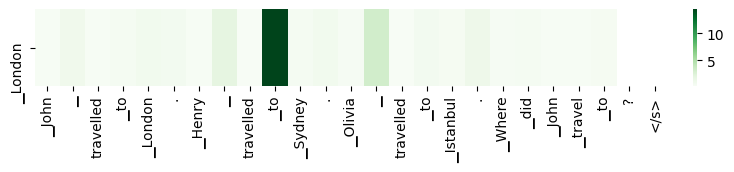

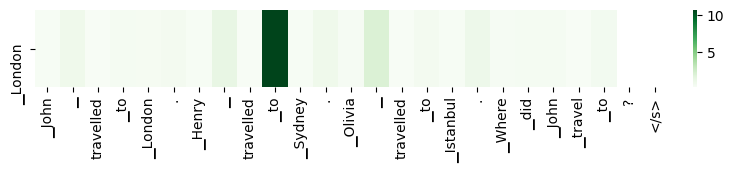

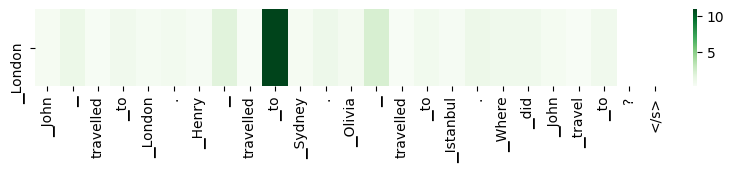

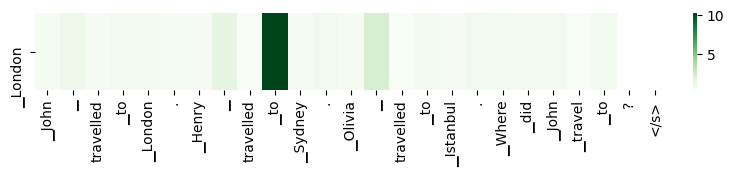

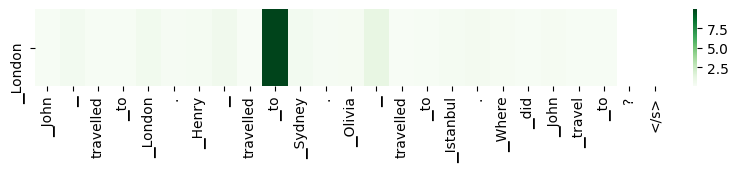

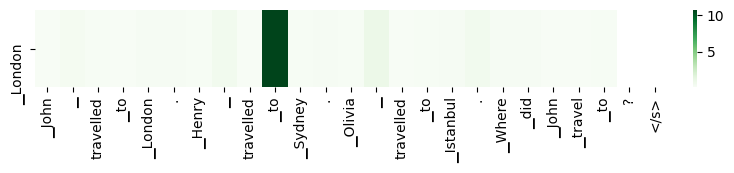

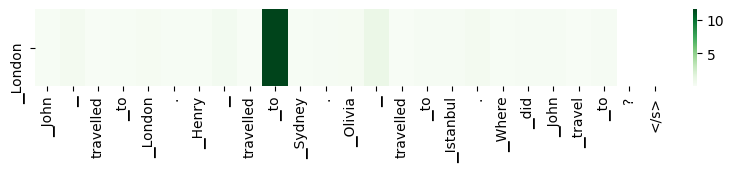

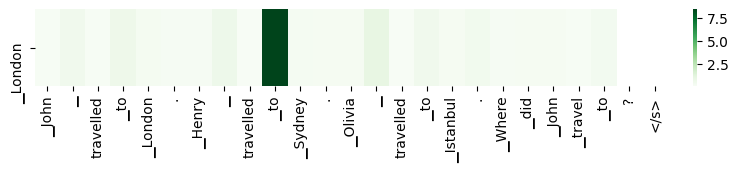

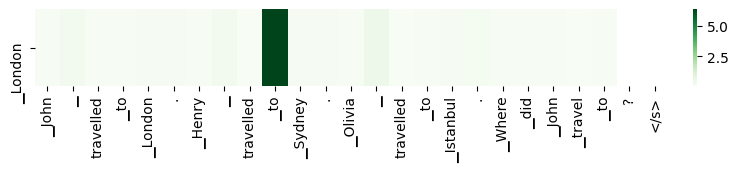

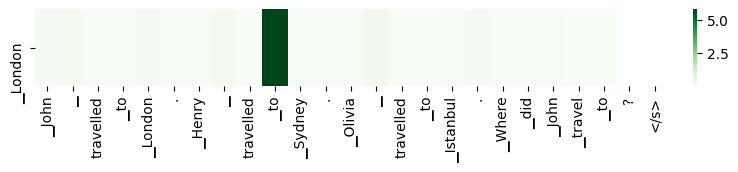

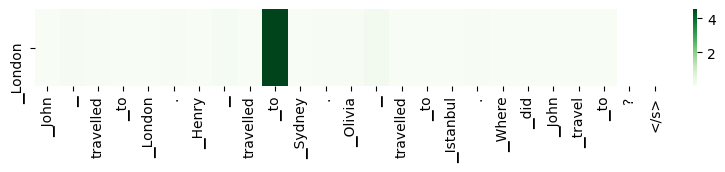

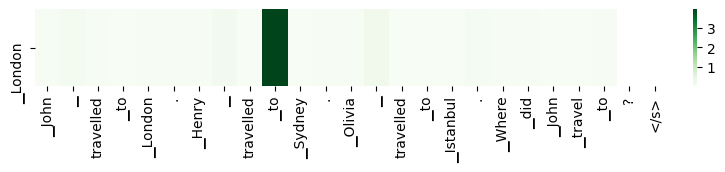

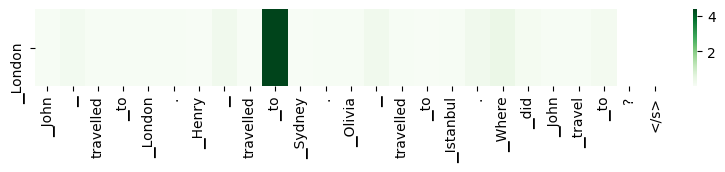

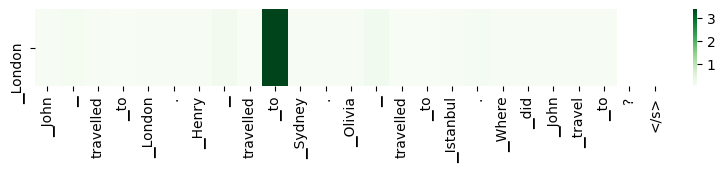

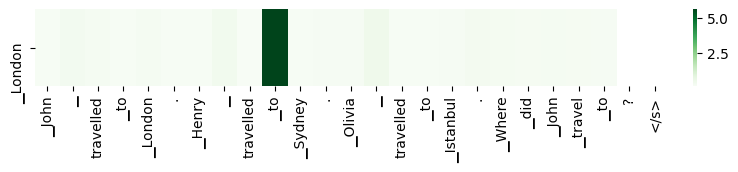

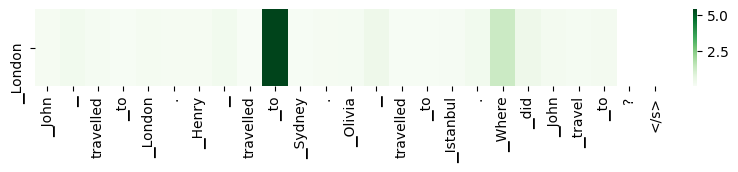

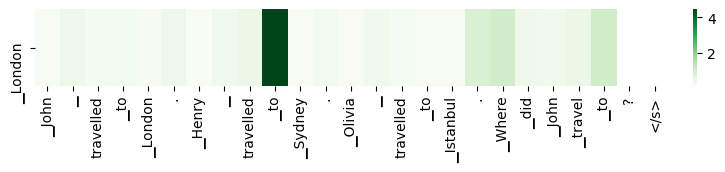

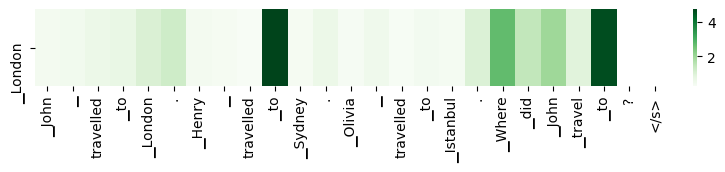

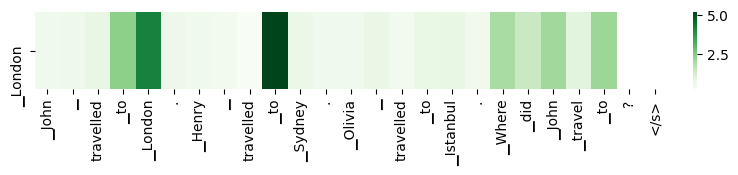

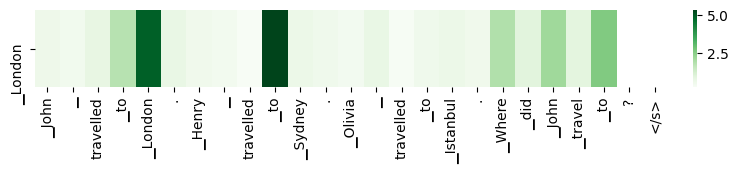

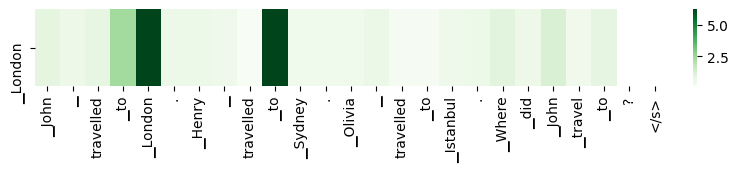

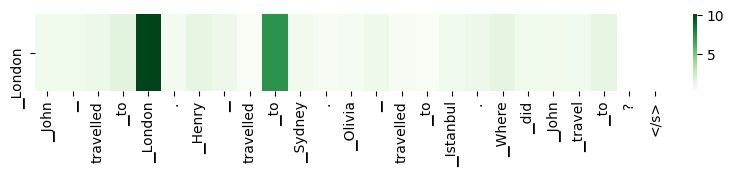

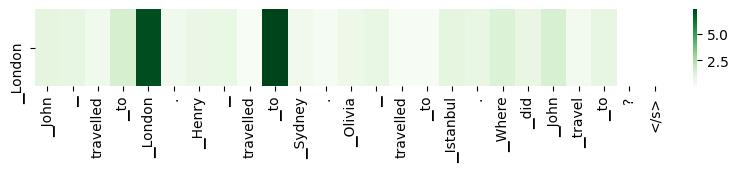

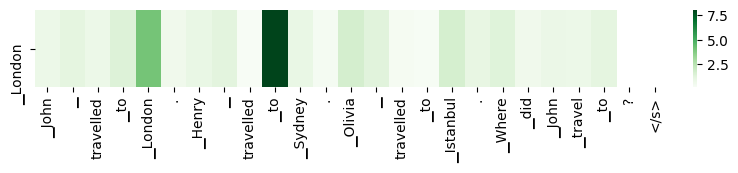

In [20]:
visualize_attn_weights(context_1, remove_last=2)

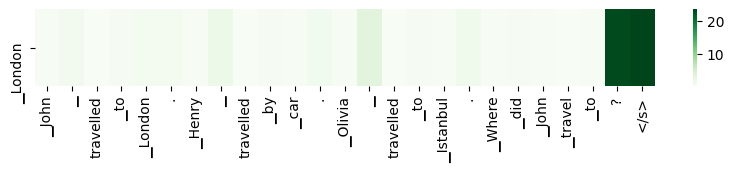

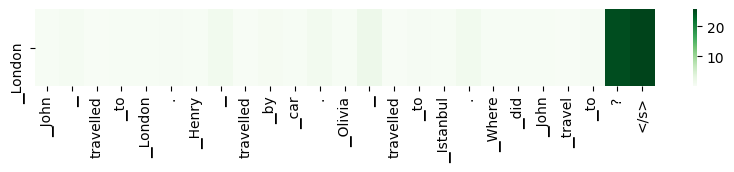

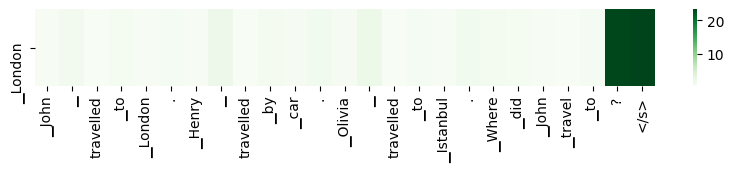

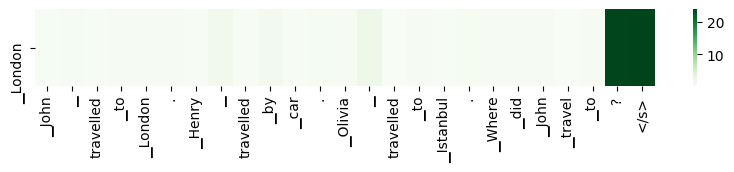

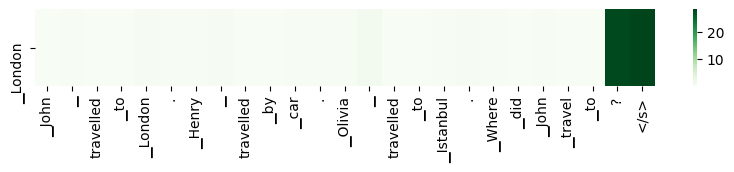

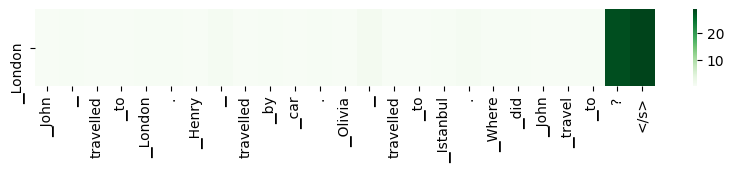

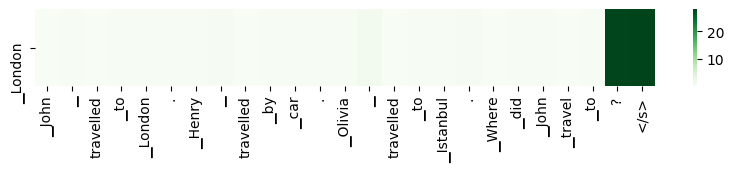

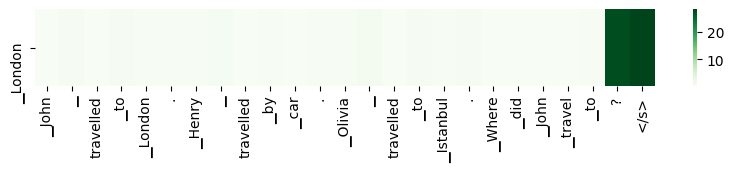

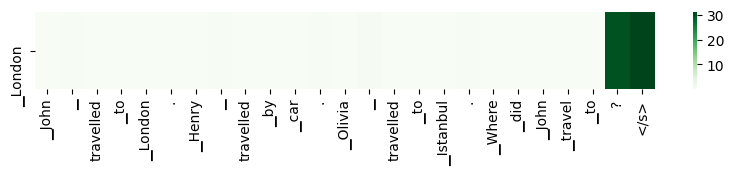

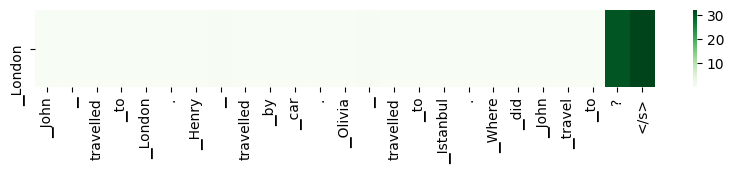

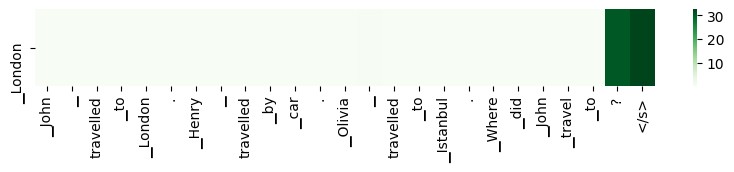

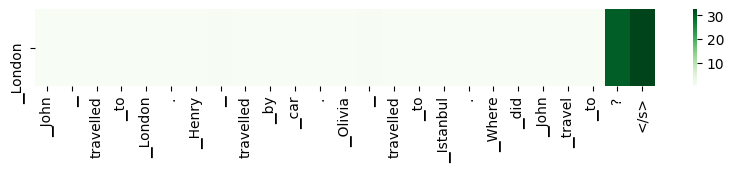

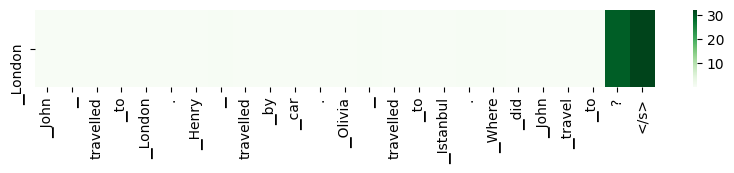

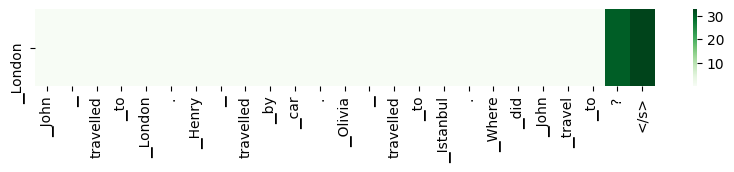

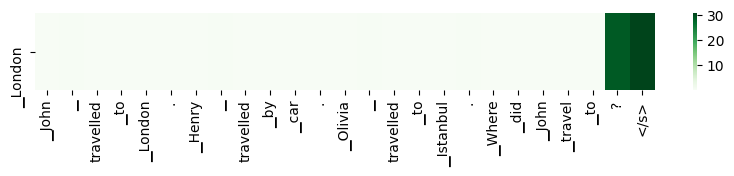

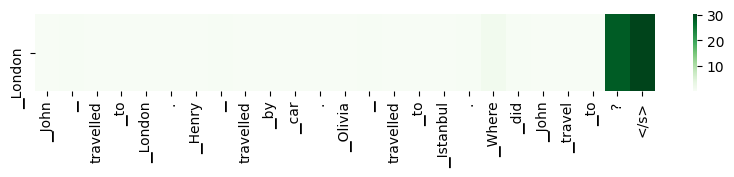

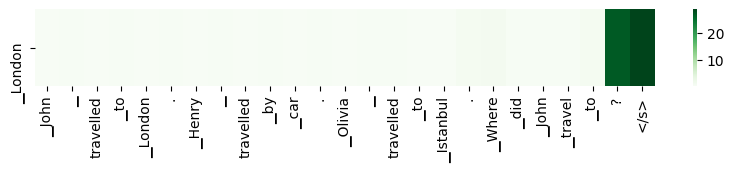

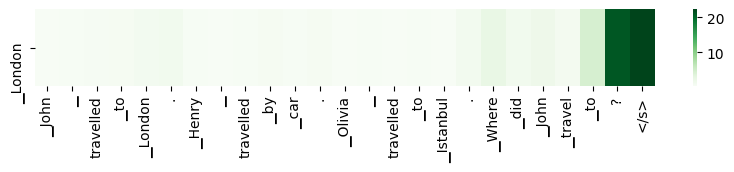

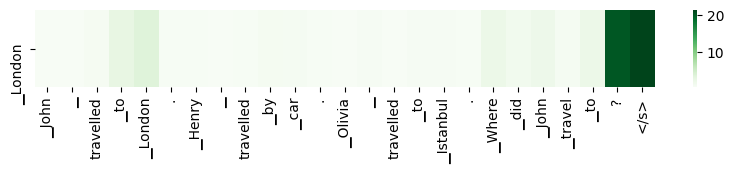

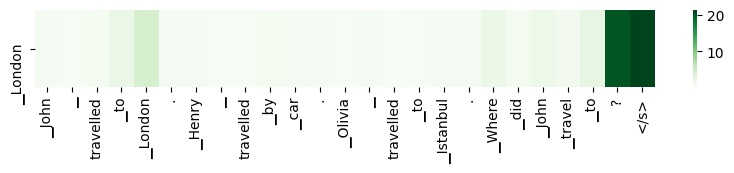

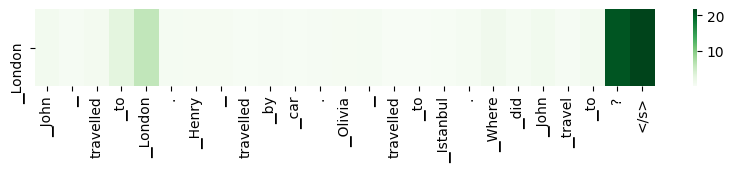

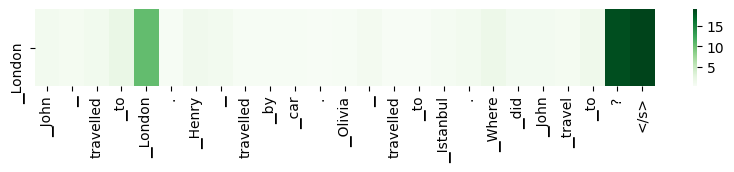

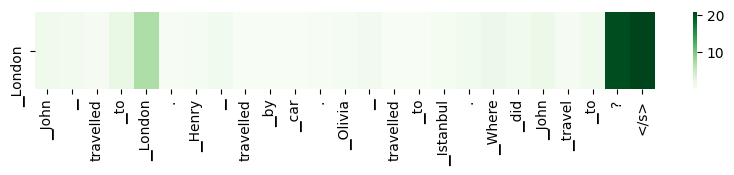

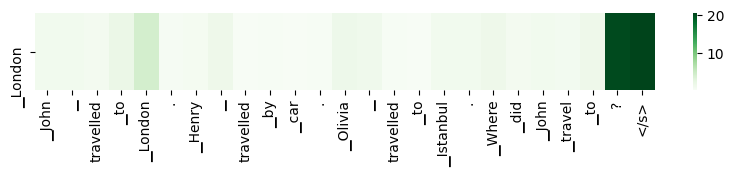

In [30]:
visualize_attn_weights("John travelled to London. Henry travelled by car. Olivia travelled to Istanbul. Where did John travel to?", remove_last=0)

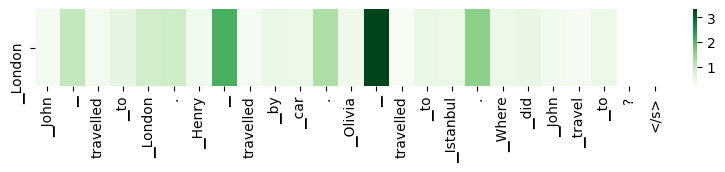

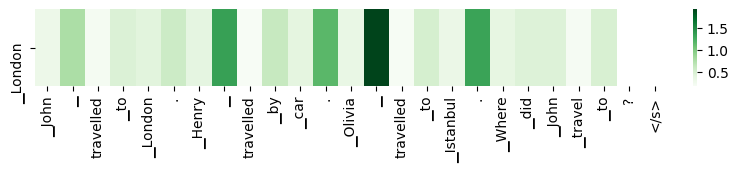

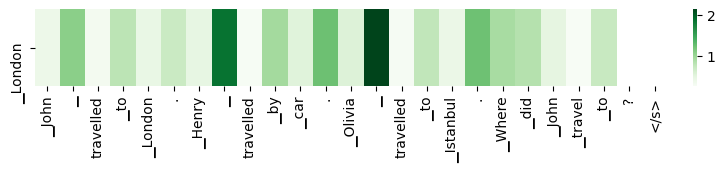

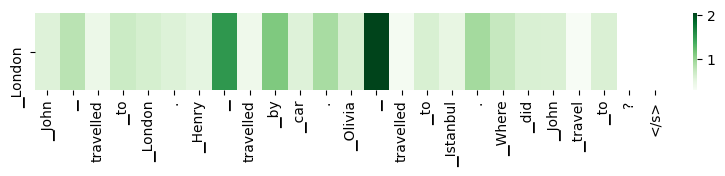

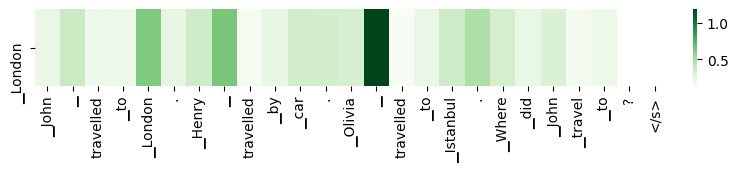

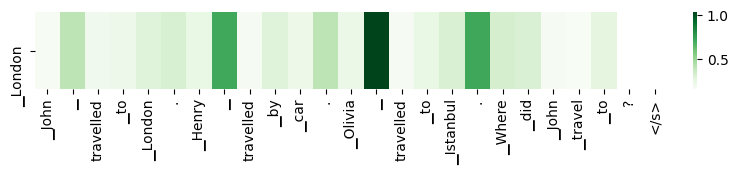

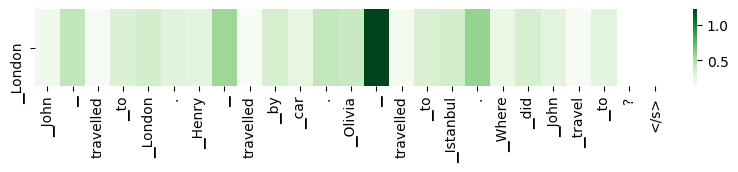

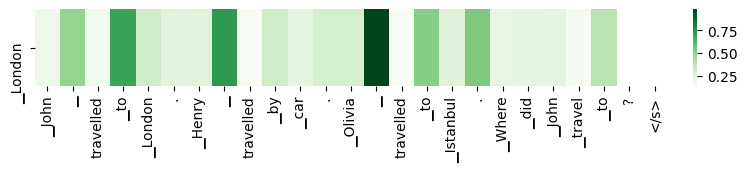

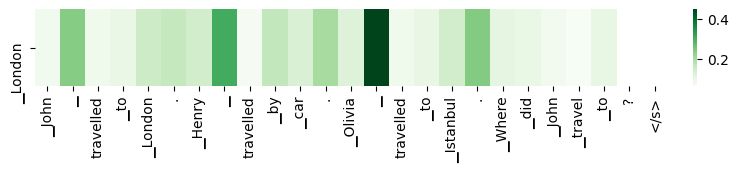

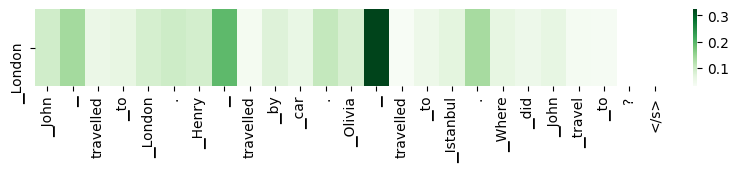

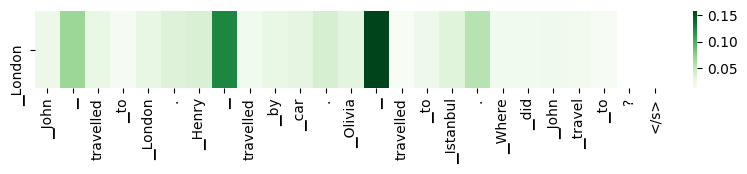

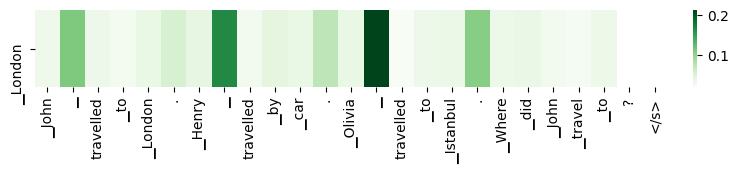

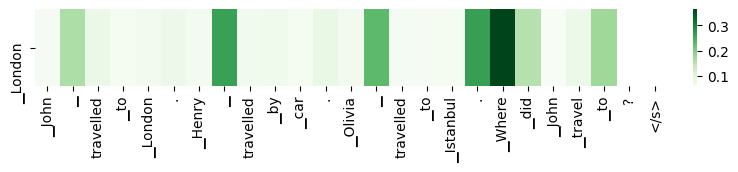

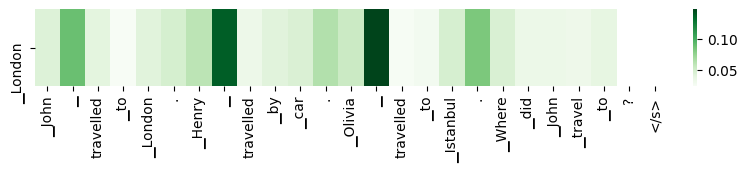

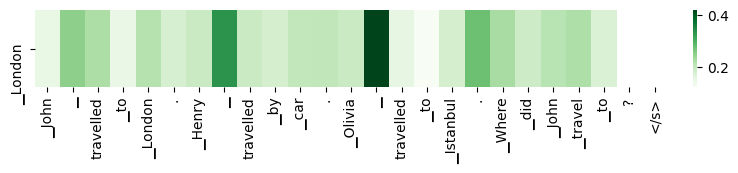

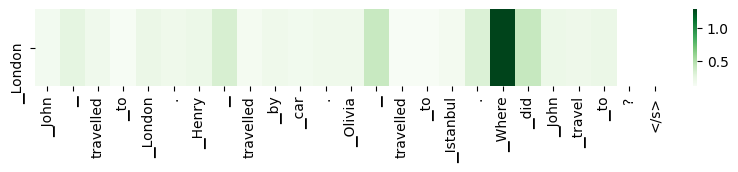

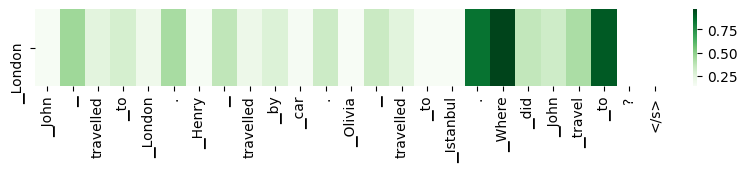

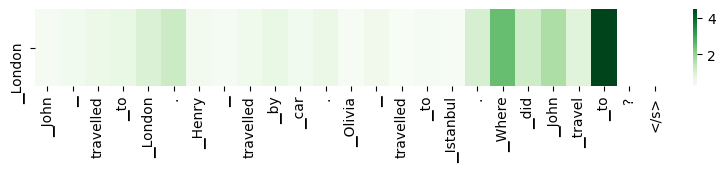

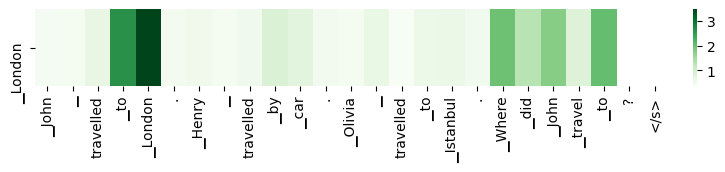

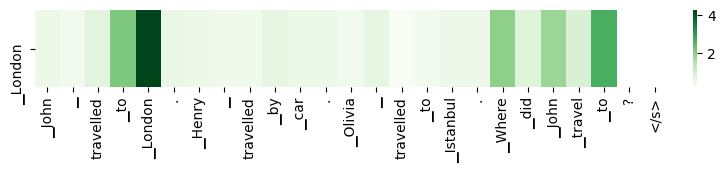

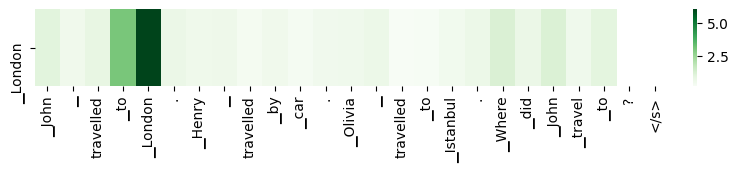

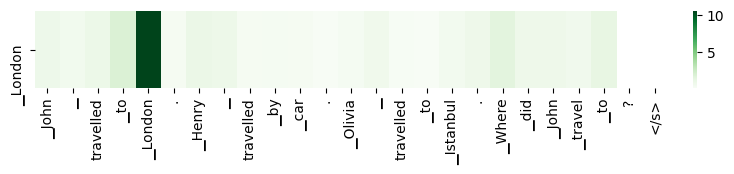

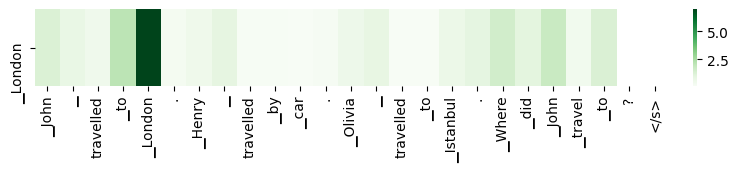

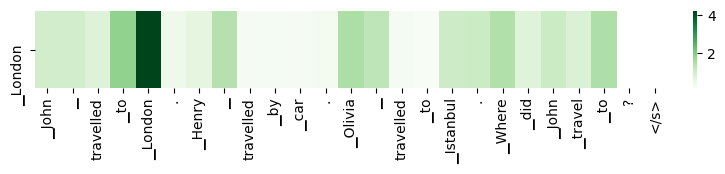

In [22]:
visualize_attn_weights("John travelled to London. Henry travelled by car. Olivia travelled to Istanbul. Where did John travel to?", remove_last=2)

In [5]:
# Multiple Choice

tm1 = Template("""Read the following context and choose the best option to answer the question.
Context: {{ context }}
Question: {{ question }}
Options:
 - {{ answer_choices | join("\n - ") }}""")

tm2 = Template("""{{ context }}
{{ question }}
- {{ answer_choices | join("\n- ") }}""")

tm3 = Template("""{{ context }}
{{ question }}
Pick the correct answer from the following options:
- {{ answer_choices | join("\n- ") }}""")

tm4 = Template("""{{ context }}
According to the above context, choose the best option to answer the following question.
Question: {{ question }}
Options:
- {{answer_choices | join("\n - ")}}
""")

tm5 = Template("""{{ context }}
{{ question }}
Pick the best answer from the following options:
A. {{ answer0 }}
B. {{ answer1 }}
C. {{ answer2 }}
D. {{ answer3 }}""")

tm6 = Template("""{{ context }}
According to the above context, choose the best option to answer the following question.
Question: {{ question }}
Options:
A. {{ answer0 }}
B. {{ answer1 }}
C. {{ answer2 }}
D. {{ answer3 }}""")

tm7 = Template("""{{ context }}
{{ question }}
A. {{ answer0 }}
B. {{ answer1 }}
C. {{ answer2 }}
D. {{ answer3 }}""")

# Open-Ended

tm8 = Template("""Question: "{{question}}"
Context: "{{context}}"
Answer:""")

tm9 = Template("""{{ context }}
Given the paragraph above, please answer correctly the following
question:
{{ question }}""")

tm10 = Template("""Given the following passage
"{{context}}",
answer the following question. Note that the answer is present within
the text.
Question: {{question}}""")

tm11 = Template("{{context}} What is the answer to: {{question}}")
